In [1]:
import os
from tqdm import tqdm
import pickle
import random
from typing import Tuple

import pandas as pd
import numpy as np
import scipy
from sklearn.metrics.pairwise import pairwise_kernels
import matplotlib.pyplot as plt
import networkx as nx

from metaspace import SMInstance
from anndata import AnnData
from metaspace2anndata import dataset_to_anndata
import scanpy as sc
import seaborn as sns
from molmass import Formula

import utils
from config import store_dir, data_dir, date_key, enrichment_dir
%load_ext autoreload
%autoreload 2

# Load data

In [2]:
store_dir

'/g/alexandr/tim/metaspace_evaluation/230201'

In [3]:
dss = pickle.load(open(os.path.join(store_dir, 'all_datasets.pickle'), "rb" ) )
results = pickle.load(open(os.path.join(store_dir, 'hmdb4_results.pickle'), "rb" ) )
hmdb_v4 = pd.read_csv(os.path.join(data_dir, 'databases/HMDB_v4.csv'), index_col=None).set_index('chemical_formula')
md = utils.make_metadata_dict(dss, results, only_results=True)
mdt = utils.clean_metadata_table(utils.metadata_dict_totable(md))

In [4]:
md = utils.make_metadata_dict(dss, results, only_results=True)
mdt = utils.clean_metadata_table(utils.metadata_dict_totable(md))

In [5]:
mdt['top_Organism'] = utils.top_feature_col(mdt['Organism'], top=10)
mdt['top_Condition'] = utils.top_feature_col(mdt['Condition'], top=10)
mdt['top_Organism_Part'] = utils.top_feature_col(mdt['Organism_Part'], top=15)
mdt['top_Polarity'] = utils.top_feature_col(mdt['Polarity'], top=10)
mdt['top_maldi_matrix'] = utils.top_feature_col(mdt['maldi_matrix'], top=8)
mdt['top_Group'] = utils.top_feature_col(mdt['Group'], top=10)

In [6]:
# adata = utils.make_ion_anndata(results, mdt, fdr_cutoff=0.5, only_onSample=True)

adata = utils.make_molecule_anndata(results, mdt, fdr_cutoff=0.2, only_onSample=True)
adata.var = adata.var.rename(columns={0: 'molecule'}).reset_index().set_index('molecule').drop(columns='index')

100%|██████████| 7443/7443 [00:12<00:00, 607.56it/s]


10865  features


100%|██████████| 7443/7443 [00:41<00:00, 178.60it/s]
/home/trose/projects/metaspace_evaluation/utils.py:186: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(X=mol_data.to_numpy(), var=pd.DataFrame(mol_features), obs=mdt.loc[mol_data.index, :])
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [7]:
sc.pp.filter_genes(adata, min_cells=100) # 200
sc.pp.filter_cells(adata, min_genes=20) # 50
sc.pp.normalize_total(adata, target_sum=1e4)
#sc.tl.pca(adata)
#sc.external.pp.bbknn(adata, batch_key='maldi_matrix', metric='euclidean', neighbors_within_batch=1)
sc.pp.neighbors(adata, metric='cosine')
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
adata

AnnData object with n_obs × n_vars = 4437 × 1631
    obs: 'Organism', 'Condition', 'Organism_Part', 'Polarity', 'maldi_matrix', 'Group', 'mzmin', 'mzmax', 'Analyzer', 'Ionisation_Source', 'top_Organism', 'top_Condition', 'top_Organism_Part', 'top_Polarity', 'top_maldi_matrix', 'top_Group', 'n_genes'
    var: 'n_cells'
    uns: 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

<AxesSubplot: xlabel='top_maldi_matrix', ylabel='count'>

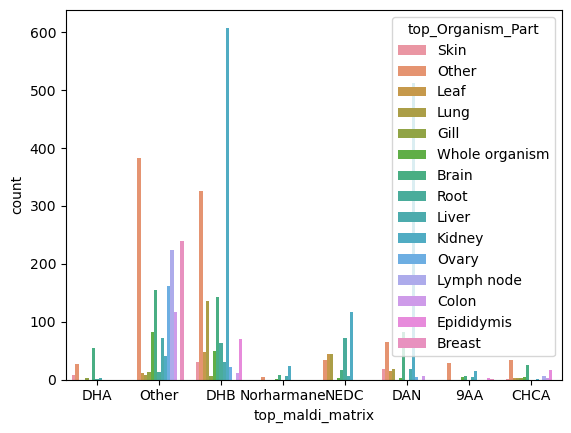

In [9]:
sns.countplot(data=adata.obs, x='top_maldi_matrix', hue='top_Organism_Part')

# Positive

In [10]:
adata_pos = adata[adata.obs['Polarity']=='Positive',:]

sc.pp.filter_genes(adata_pos, min_cells=100) # 200
sc.pp.filter_cells(adata_pos, min_genes=20) # 50
sc.pp.normalize_total(adata_pos, target_sum=1e4)

#sc.pp.neighbors(adata_pos, metric='cosine')
#sc.tl.leiden(adata_pos)
#sc.tl.umap(adata_pos)

adata_pos.var['mass'] = [Formula(x).mass for x in adata_pos.var.index.values]

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


## Metabolites

### MZ range

In [11]:
adata_pos_met = adata_pos[:,adata_pos.var['mass'] <= 350]
adata_pos_met = adata_pos_met[:,adata_pos_met.var['mass'] >= 100]

sc.pp.filter_genes(adata_pos_met, min_cells=100) # 200
sc.pp.filter_cells(adata_pos_met, min_genes=20)
#sc.pp.normalize_total(adata_pos_met, target_sum=1e4)

sc.pp.pca(adata_pos_met)
sc.pp.neighbors(adata_pos_met, metric='cosine')
sc.tl.leiden(adata_pos_met)
sc.tl.umap(adata_pos_met)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


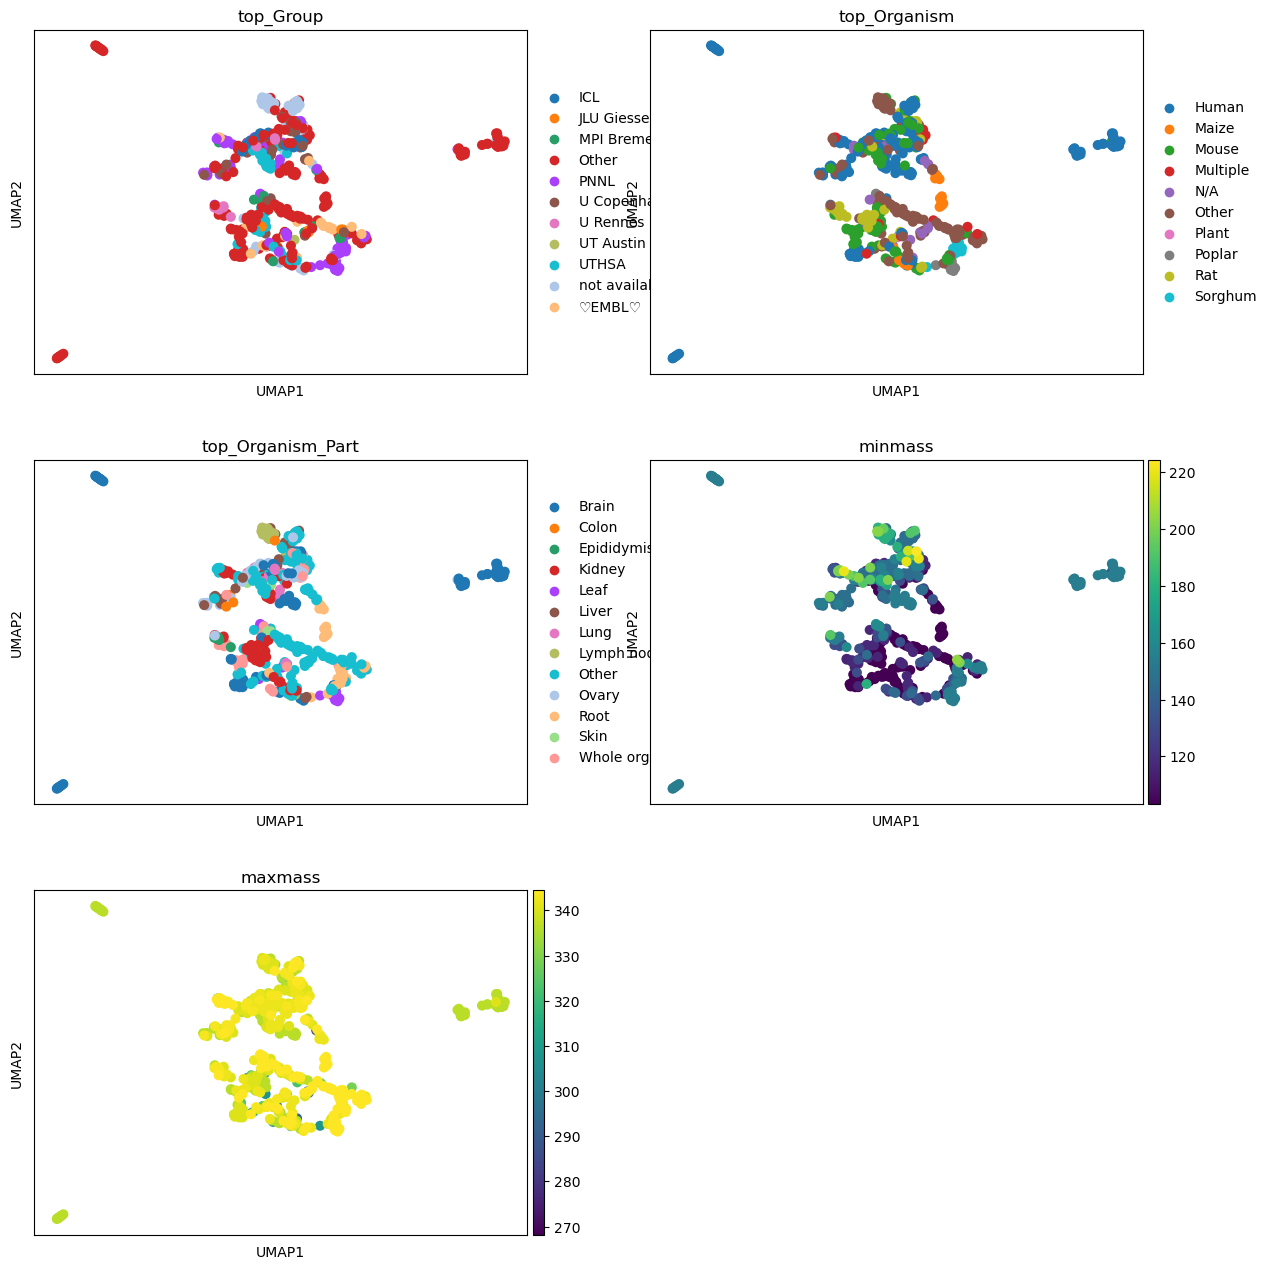

In [12]:
utils.update_minmax_mass(adata_pos_met)
sc.pl.umap(adata_pos_met, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

In [13]:
adata_pos_met

AnnData object with n_obs × n_vars = 571 × 149
    obs: 'Organism', 'Condition', 'Organism_Part', 'Polarity', 'maldi_matrix', 'Group', 'mzmin', 'mzmax', 'Analyzer', 'Ionisation_Source', 'top_Organism', 'top_Condition', 'top_Organism_Part', 'top_Polarity', 'top_maldi_matrix', 'top_Group', 'n_genes', 'leiden', 'minmass', 'maxmass'
    var: 'n_cells', 'mass'
    uns: 'neighbors', 'umap', 'pca', 'leiden', 'top_Group_colors', 'top_Organism_colors', 'top_Organism_Part_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### Matrix

<AxesSubplot: xlabel='top_maldi_matrix', ylabel='count'>

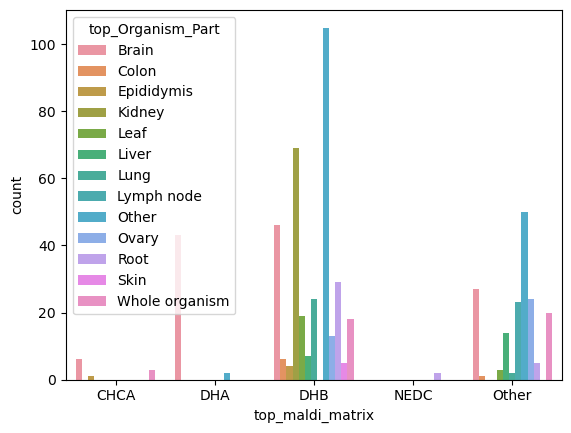

In [14]:
sns.countplot(data=adata_pos_met.obs, x='top_maldi_matrix', hue='top_Organism_Part')

In [15]:
adata_pos_met_matrix = adata_pos_met[adata_pos_met.obs['top_maldi_matrix']=='DHB',:]

sc.pp.pca(adata_pos_met_matrix)
sc.pp.neighbors(adata_pos_met_matrix, metric='cosine')
sc.tl.leiden(adata_pos_met_matrix)
sc.tl.umap(adata_pos_met_matrix)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


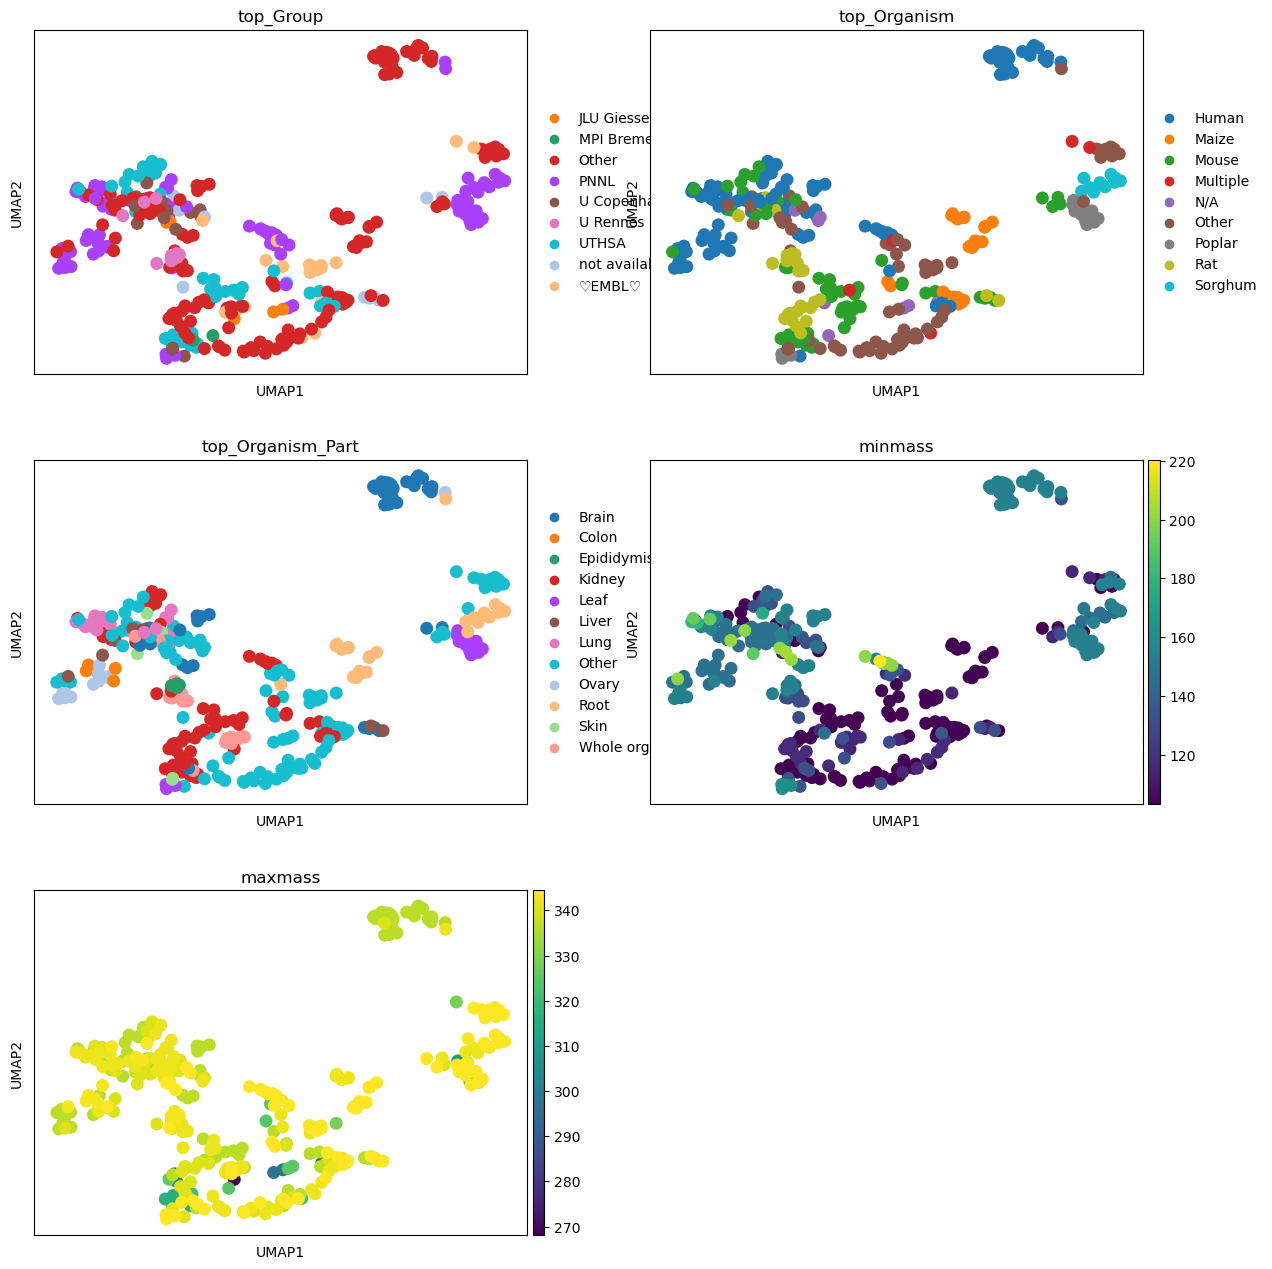

In [16]:
utils.update_minmax_mass(adata_pos_met_matrix)
sc.pl.umap(adata_pos_met_matrix, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

In [17]:
adata_pos_met_matrix

AnnData object with n_obs × n_vars = 345 × 149
    obs: 'Organism', 'Condition', 'Organism_Part', 'Polarity', 'maldi_matrix', 'Group', 'mzmin', 'mzmax', 'Analyzer', 'Ionisation_Source', 'top_Organism', 'top_Condition', 'top_Organism_Part', 'top_Polarity', 'top_maldi_matrix', 'top_Group', 'n_genes', 'leiden', 'minmass', 'maxmass'
    var: 'n_cells', 'mass'
    uns: 'neighbors', 'umap', 'pca', 'leiden', 'top_Group_colors', 'top_Organism_colors', 'top_Organism_Part_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### Select tissues

In [18]:
adata_pos_met_matrix.obs.Organism_Part.value_counts(ascending=False)

Kidney                69
Brain                 46
Root                  29
Lung                  24
Thorax exoskeleton    20
Leaf                  19
Whole organism        18
Ovary                 13
Berry                 10
Seed                  10
Embryo                 7
Other                  7
Liver                  7
Colon                  6
Microbial colony       5
Agar growth            5
Skin                   5
Sciatic nerve          5
Epididymis             4
Cells                  4
Buccal mucosa          3
Tooth                  2
intestinal tract       2
standards              2
Muscle                 2
Retina                 2
GEMM Tumor             2
Colonies               2
Bone                   2
wafer                  2
Root/soil              1
Prostate               1
Amoeba                 1
Skin Tumor             1
Small intestine        1
Stem                   1
Stomach                1
EMT6 Tumors            1
Whole embryo           1
Bone marrow            1


In [19]:
# Tissues
tissue_list = ['Kidney', 'Brain', 'Lung', 'Ovary']

adata_pos_met_matrix_tissue = adata_pos_met_matrix[adata_pos_met_matrix.obs['Organism_Part'].isin(tissue_list), :]

#sc.pp.filter_genes(adata_pos_met_matrix_tissue, min_cells=5)

sc.pp.pca(adata_pos_met_matrix_tissue)
sc.pp.neighbors(adata_pos_met_matrix_tissue, metric='cosine')
sc.tl.leiden(adata_pos_met_matrix_tissue)
sc.tl.umap(adata_pos_met_matrix_tissue)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


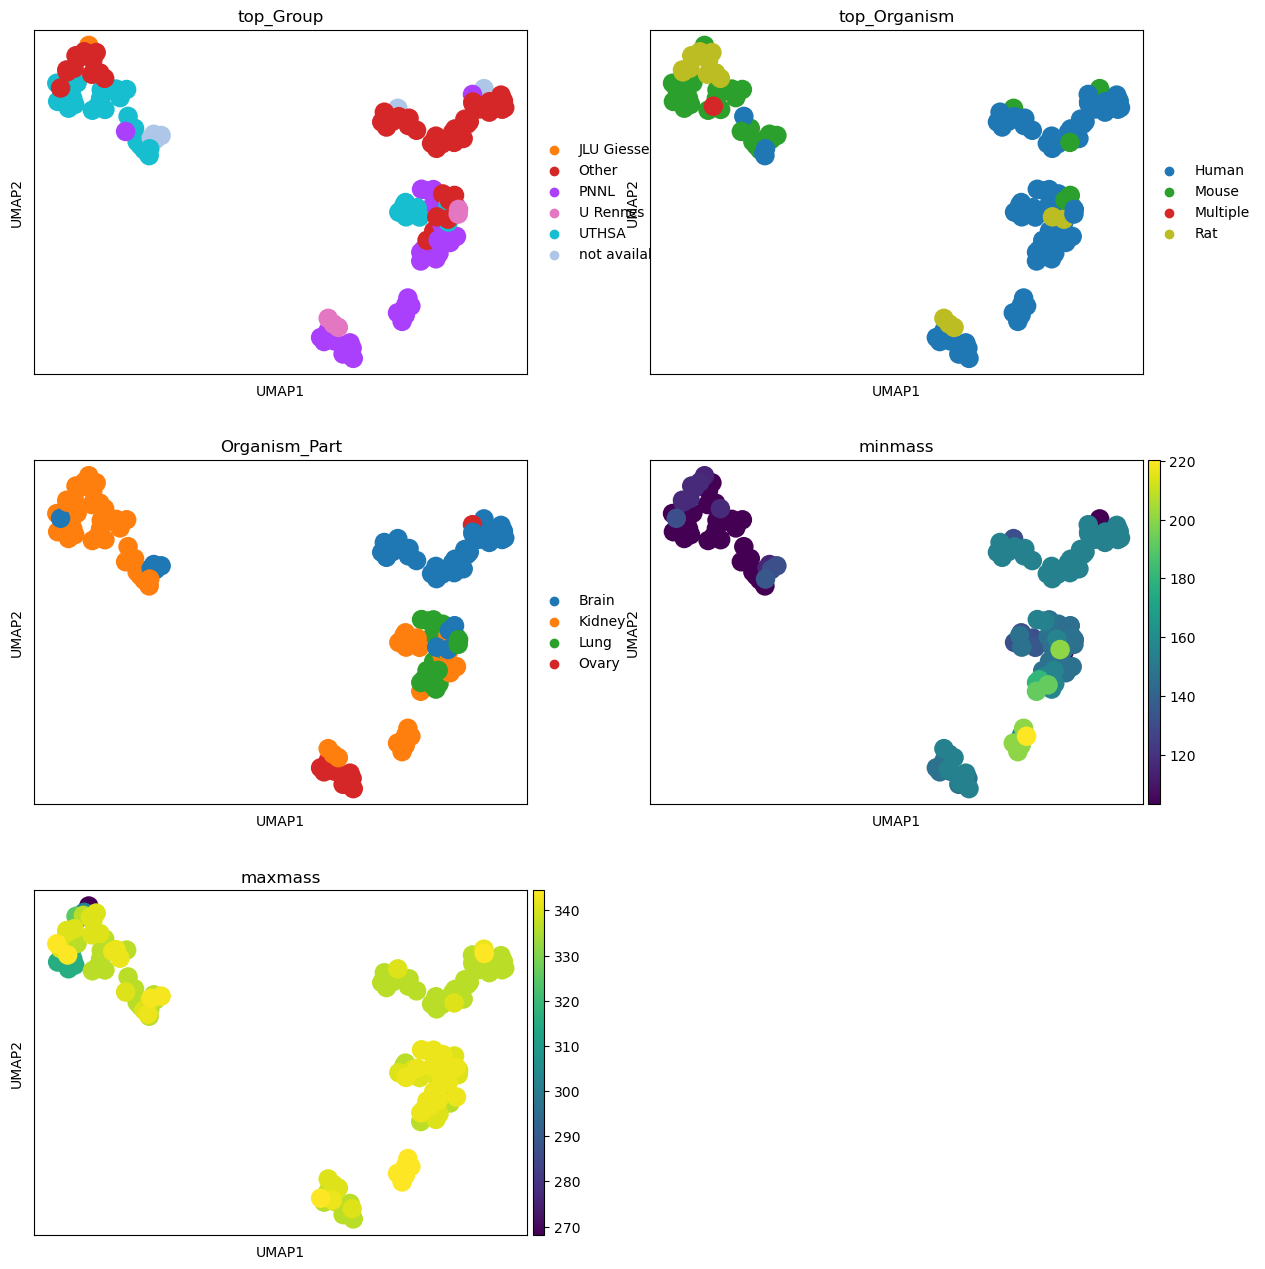

In [20]:
utils.update_minmax_mass(adata_pos_met_matrix_tissue)
sc.pl.umap(adata_pos_met_matrix_tissue, color=['top_Group', 'top_Organism', 'Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

In [21]:
adata_pos_met_matrix_tissue

AnnData object with n_obs × n_vars = 152 × 149
    obs: 'Organism', 'Condition', 'Organism_Part', 'Polarity', 'maldi_matrix', 'Group', 'mzmin', 'mzmax', 'Analyzer', 'Ionisation_Source', 'top_Organism', 'top_Condition', 'top_Organism_Part', 'top_Polarity', 'top_maldi_matrix', 'top_Group', 'n_genes', 'leiden', 'minmass', 'maxmass'
    var: 'n_cells', 'mass'
    uns: 'neighbors', 'umap', 'pca', 'leiden', 'top_Group_colors', 'top_Organism_colors', 'top_Organism_Part_colors', 'Organism_Part_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### Tissue prototyping

In [22]:
pos_met_mol_freq = {}
pos_met_mol2_freq = {}
pos_met_top_datasets = {}

mol_freq_cutoff = 0.1 # Initial: 0.1
top_ds_cutoff = 0.2 # Initial: 0.2

#### Kidney

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


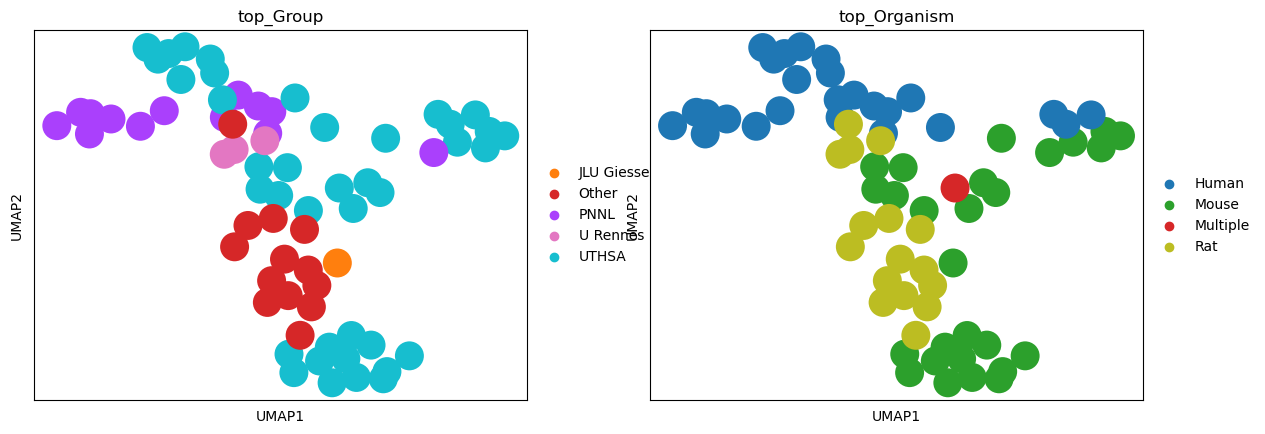

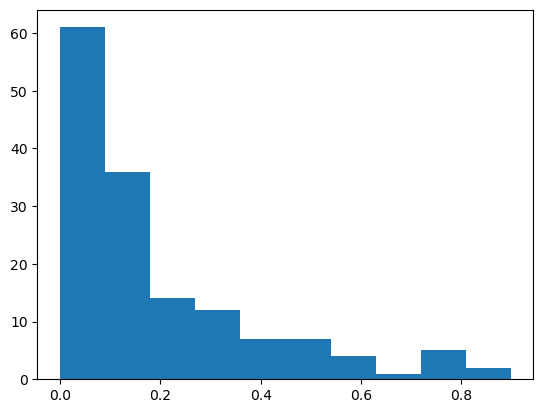

2022-11-18_19h57m36s    14
2022-11-18_20h04m21s    14
2022-11-18_19h35m10s    13
2022-11-18_19h16m17s    15
2022-11-18_19h12m52s    14
2022-11-18_19h09m21s    15
2022-11-18_18h58m18s    14
2022-11-18_18h52m17s    15
2019-08-02_22h43m20s    13
2019-08-02_00h07m33s    13
2019-07-23_23h36m29s    13
2019-07-23_22h22m30s    13
2019-07-19_19h41m43s    13
2018-06-16_05h23m01s    13
2018-06-13_18h49m40s    13
dtype: int64


In [23]:
tissue = 'Kidney'
adat = adata_pos_met_matrix_tissue[adata_pos_met_matrix_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

utils.update_minmax_mass(adat)

sc.pl.umap(adat, color=['top_Group', 'top_Organism'], # , 'minmass', 'maxmass' 
           ncols=2)

pos_met_mol2_freq[tissue], pos_met_top_datasets[tissue] , pos_met_mol_freq[tissue] = utils.tissue_prototyping(adat, 
                                                                                                              mol_freq_cutoff=mol_freq_cutoff, 
                                                                                                              top_ds_cutoff=top_ds_cutoff)

# pd.DataFrame(pos_met_mol2_freq[tissue].index).to_csv(os.path.join(enrichment_dir, f'features_pos_{tissue}.csv'))

print(pos_met_top_datasets[tissue])

In [24]:
utils.annotations_list(pos_met_mol2_freq[tissue].index, hmdb_v4, n=4)

C5H5N5  -  ['Adenine']
C13H17NO3  -  ['Pandamarilactam 3x']
C3H10NO4P  -  ['N-Methylethanolaminium phosphate']
C17H15NO4  -  ['(S)-Annocherine A']
C8H20NO6P  -  ['Glycerophosphocholine']
C16H13O6  -  ['3,5,7-trihydroxy-2-(4-hydroxy-3-methoxyphenyl)-1λ⁴-chromen-1-ylium', '3,5,7-trihydroxy-2-(4-hydroxy-3-methoxyphenyl)-5H-chromen-5-yl', '3,5,6,7-tetrahydroxy-2-(3-methoxyphenyl)-8aH-chromen-8a-yl', '3,5,7-trihydroxy-2-(3-hydroxy-5-methoxyphenyl)-5H-chromen-5-yl']
C10H11NO  -  ['Tryptophol', '(R)-Boschniakine', '1-(2,3-Dihydro-1H-pyrrolizin-5-yl)-2-propen-1-one', '3-[(5-Methyl-2-furanyl)methyl]-1H-pyrrole']
C9H17NO4  -  ['L-Acetylcarnitine', 'N-Lactoylleucine', '1-Carboxyethylleucine']
C17H13NO3  -  ['Graveolinine', 'Graveoline', 'Avenalumin II']
C5H13NO
C17H17NO5  -  ['Citpressine II', '(2E)-N-[2-(3,4-dihydroxyphenyl)-2-hydroxyethyl]-3-(4-hydroxyphenyl)prop-2-enimidic acid', '(2E)-3-(3,4-dihydroxyphenyl)-N-[2-hydroxy-2-(4-hydroxyphenyl)ethyl]prop-2-enimidic acid', '(2E)-3-(3,4-dihydroxyph

#### Brain

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


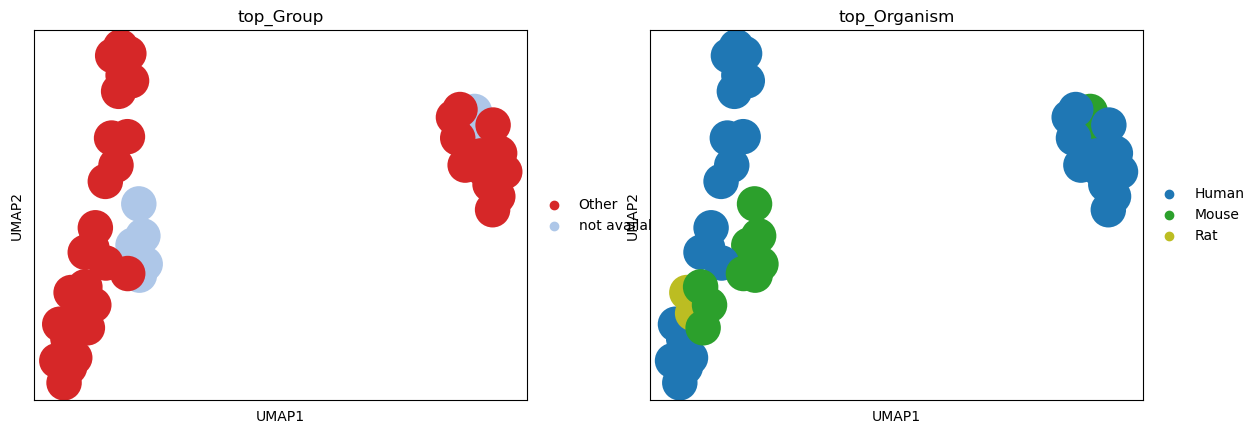

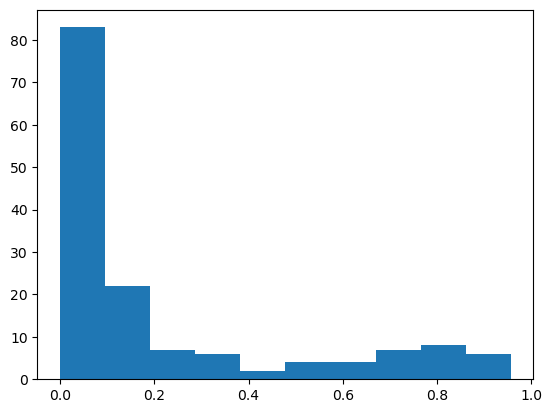

2018-08-01_14h29m27s    15
2018-08-01_14h29m09s    15
2018-08-01_14h28m50s    15
2018-08-01_14h28m11s    15
2018-08-01_14h27m50s    15
2018-08-01_14h27m24s    15
2018-08-01_14h27m07s    15
2018-08-01_14h26m50s    15
2018-08-01_14h26m33s    15
2018-08-01_14h26m17s    15
2018-08-01_14h25m56s    15
2018-08-01_14h25m21s    15
2018-08-01_14h24m55s    15
2018-08-01_14h24m33s    15
2018-08-01_14h24m14s    15
2018-08-01_14h21m22s    15
2018-08-01_14h21m02s    15
2018-08-01_14h20m46s    15
2018-08-01_14h20m30s    15
2018-06-13_12h18m22s    15
2018-05-30_13h29m30s    15
dtype: int64
C13H8F2O3  -  ['Diflunisal']
C13H17NO3  -  ['Pandamarilactam 3x']
C14H12O7  -  ['Cordeauxione']
C14H10O6  -  ['BR-Xanthone B', 'Alloathyriol', '1,3,6-Trihydroxy-5-methoxyxanthone', '3,7,8,9-tetrahydroxy-1-methyl-6H-benzo[c]chromen-6-one']
C7H6O4  -  ['Gentisic acid', '2-Pyrocatechuic acid', 'Protocatechuic acid', '2,6-Dihydroxybenzoic acid']
C13H10N2O5  -  ["cis,trans-5'-Hydroxythalidomide", '5-Hydroxythalidomide', '

In [25]:
tissue = 'Brain'
adat = adata_pos_met_matrix_tissue[adata_pos_met_matrix_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

utils.update_minmax_mass(adat)

sc.pl.umap(adat, color=['top_Group', 'top_Organism'], # , 'minmass', 'maxmass' 
           ncols=2)

pos_met_mol2_freq[tissue], pos_met_top_datasets[tissue] , pos_met_mol_freq[tissue] = utils.tissue_prototyping(adat, 
                                                                                                              mol_freq_cutoff=mol_freq_cutoff, 
                                                                                                              top_ds_cutoff=top_ds_cutoff)
#pd.DataFrame(mol_freq2.index).to_csv(os.path.join(enrichment_dir, f'features_pos_{tissue}.csv'))

print(pos_met_top_datasets[tissue])
utils.annotations_list(pos_met_mol2_freq[tissue].index, hmdb_v4, n=4)

#### Lung

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


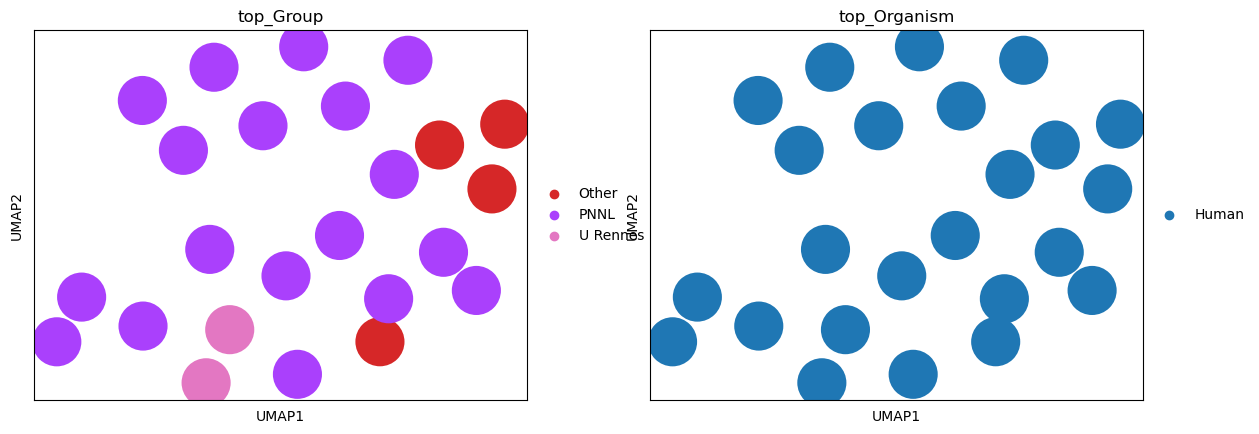

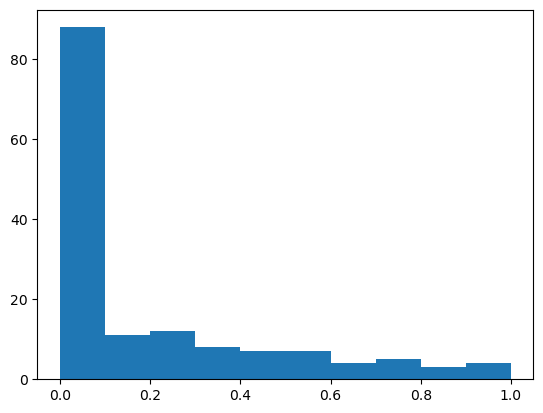

2023-01-25_03h20m26s    15
2022-10-17_20h30m37s    16
2022-10-17_20h24m34s    16
2022-09-24_00h13m14s    15
2022-09-24_00h10m42s    15
2021-10-11_22h02m30s    15
dtype: int64
C12H8O4  -  ['Methoxsalen', 'Bergapten', '4-hydroxy-7-methyl-5H-furo[2,3-g]isochromen-5-one']
C14H12O7  -  ['Cordeauxione']
C14H10O6  -  ['BR-Xanthone B', 'Alloathyriol', '1,3,6-Trihydroxy-5-methoxyxanthone', '3,7,8,9-tetrahydroxy-1-methyl-6H-benzo[c]chromen-6-one']
C13H10O5  -  ['Isopimpinellin', 'Coriandrone C']
C17H15NO4  -  ['(S)-Annocherine A']
C10H12N4O5  -  ['Inosine', 'Allopurinol riboside', 'Arabinosylhypoxanthine']
C13H8O5  -  ['Urolithin C', 'Gentisein', '3,8,10-trihydroxy-6H-benzo[c]chromen-6-one', '3,4,8-trihydroxy-6H-benzo[c]chromen-6-one']
C16H13O6  -  ['3,5,7-trihydroxy-2-(4-hydroxy-3-methoxyphenyl)-1λ⁴-chromen-1-ylium', '3,5,7-trihydroxy-2-(4-hydroxy-3-methoxyphenyl)-5H-chromen-5-yl', '3,5,6,7-tetrahydroxy-2-(3-methoxyphenyl)-8aH-chromen-8a-yl', '3,5,7-trihydroxy-2-(3-hydroxy-5-methoxyphenyl)-5H-c

In [26]:
tissue = 'Lung'
adat = adata_pos_met_matrix_tissue[adata_pos_met_matrix_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

utils.update_minmax_mass(adat)

sc.pl.umap(adat, color=['top_Group', 'top_Organism'], # , 'minmass', 'maxmass' 
           ncols=2)

pos_met_mol2_freq[tissue], pos_met_top_datasets[tissue] , pos_met_mol_freq[tissue] = utils.tissue_prototyping(adat, 
                                                                                                              mol_freq_cutoff=mol_freq_cutoff, 
                                                                                                              top_ds_cutoff=top_ds_cutoff)
#pd.DataFrame(mol_freq2.index).to_csv(os.path.join(enrichment_dir, f'features_pos_{tissue}.csv'))

print(pos_met_top_datasets[tissue])
utils.annotations_list(pos_met_mol2_freq[tissue].index, hmdb_v4, n=4)

#### Ovary

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


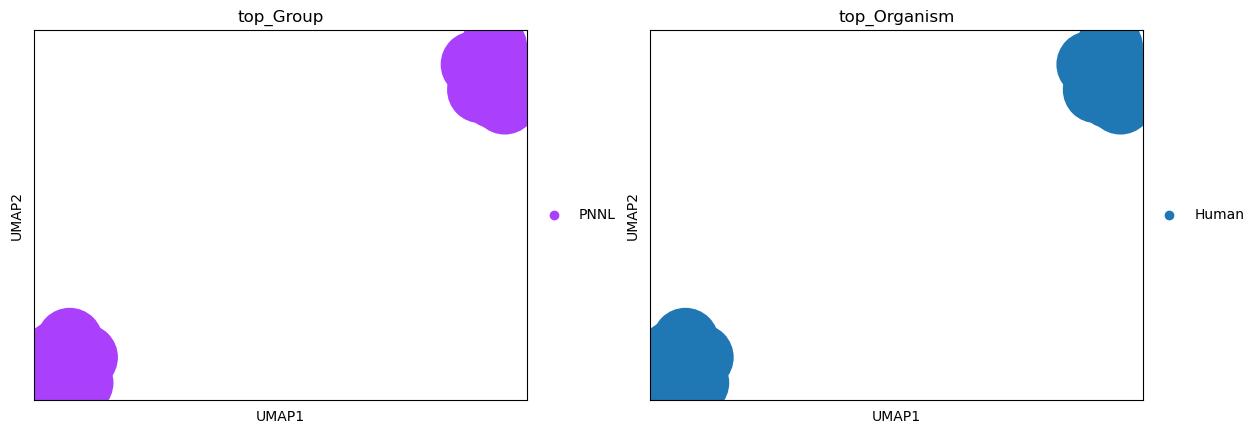

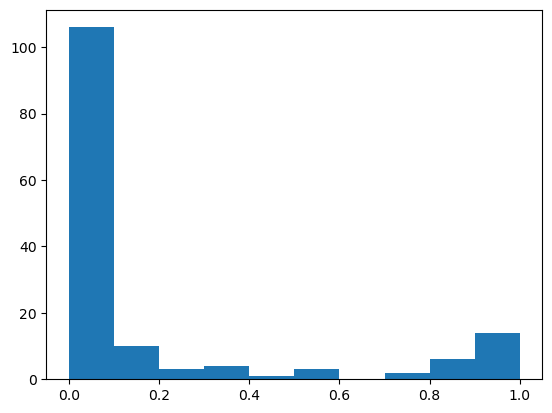

2021-11-19_23h25m16s    20
2021-11-19_23h21m55s    20
2021-11-19_23h17m05s    20
2021-11-19_23h09m34s    20
2021-11-18_20h10m13s    20
2021-11-18_20h09m36s    20
dtype: int64
C13H17NO3  -  ['Pandamarilactam 3x']
C14H12O7  -  ['Cordeauxione']
C14H10O6  -  ['BR-Xanthone B', 'Alloathyriol', '1,3,6-Trihydroxy-5-methoxyxanthone', '3,7,8,9-tetrahydroxy-1-methyl-6H-benzo[c]chromen-6-one']
C18H10O6  -  ["7,7'-Dihydroxy-6,8'-bicoumarin"]
C7H6O4  -  ['Gentisic acid', '2-Pyrocatechuic acid', 'Protocatechuic acid', '2,6-Dihydroxybenzoic acid']
C10H17N3O6S  -  ['Glutathione', 'Glutathionate(1-)']
C8H20NO6P  -  ['Glycerophosphocholine']
C17H11N5  -  ['Letrozole']
C14H10O8  -  ['2-(3,4-Dihydroxybenzoyloxy)-4,6-dihydroxybenzoate']
C11H16O9  -  ['6-[(3-carboxy-2-methylprop-2-en-1-yl)oxy]-3,4,5-trihydroxyoxane-2-carboxylic acid', '3,4,5-trihydroxy-6-[(4-hydroxy-3-methylbut-2-enoyl)oxy]oxane-2-carboxylic acid', '6-(3,3-dimethyloxirane-2-carbonyloxy)-3,4,5-trihydroxyoxane-2-carboxylic acid', '6-[(2Z)-2-ca

In [27]:
tissue = 'Ovary'
adat = adata_pos_met_matrix_tissue[adata_pos_met_matrix_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

utils.update_minmax_mass(adat)

sc.pl.umap(adat, color=['top_Group', 'top_Organism'], # , 'minmass', 'maxmass' 
           ncols=2)

pos_met_mol2_freq[tissue], pos_met_top_datasets[tissue] , pos_met_mol_freq[tissue] = utils.tissue_prototyping(adat, 
                                                                                                              mol_freq_cutoff=mol_freq_cutoff, 
                                                                                                              top_ds_cutoff=top_ds_cutoff)
#pd.DataFrame(mol_freq2.index).to_csv(os.path.join(enrichment_dir, f'features_pos_{tissue}.csv'))

print(pos_met_top_datasets[tissue])
utils.annotations_list(pos_met_mol2_freq[tissue].index, hmdb_v4, n=4)

### Tissue similarity

In [28]:
freq_tab = pd.DataFrame(pos_met_mol2_freq).transpose()
freq_tab[freq_tab.isna()] = 0
sim_tab = pd.DataFrame(pairwise_kernels(freq_tab, metric='cosine'), index=freq_tab.index, columns=freq_tab.index)

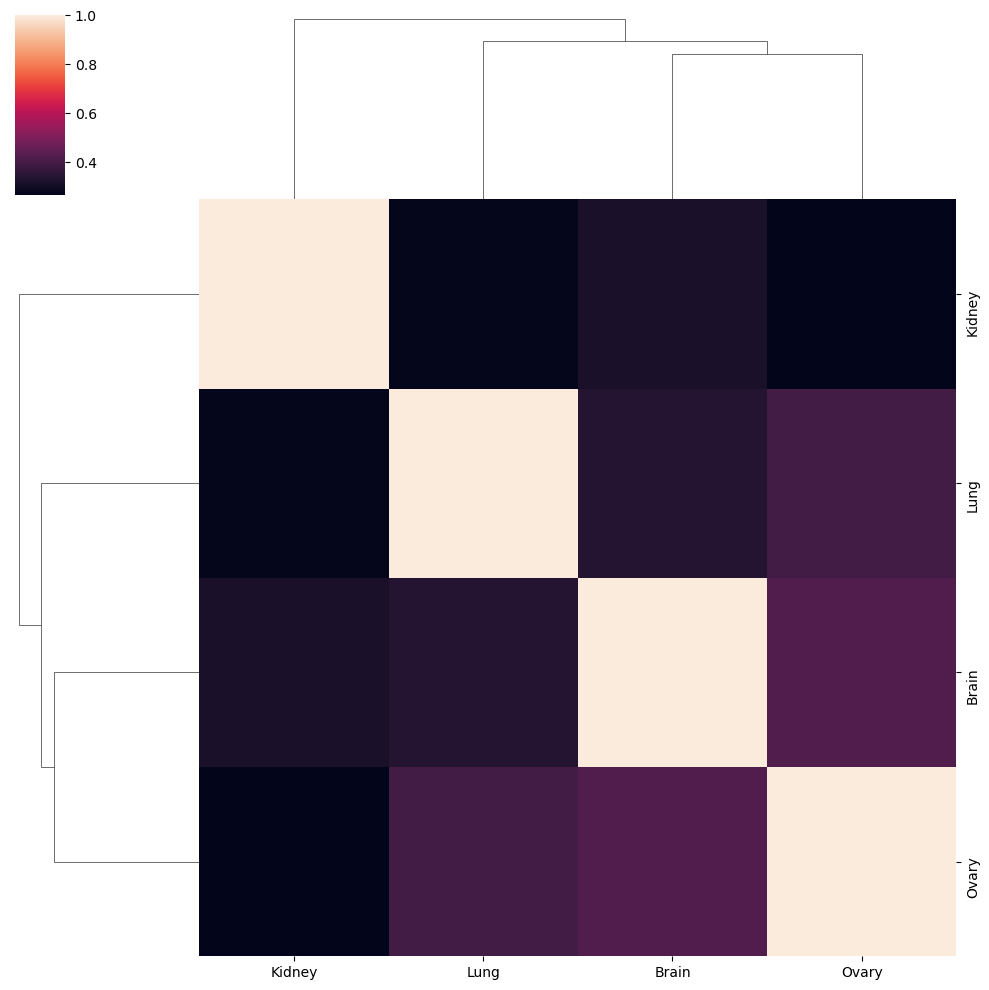

In [29]:
sns.clustermap(sim_tab)

In [30]:
tmp_sim_tab = sim_tab.copy()
tmp_sim_tab[tmp_sim_tab<0.2] = 0
g = nx.from_pandas_adjacency(tmp_sim_tab)
g.remove_edges_from(nx.selfloop_edges(g))

/tmp/ipykernel_76/2865731970.py:10: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


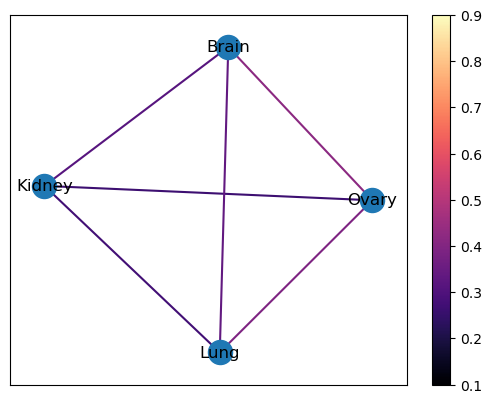

In [31]:
pos = nx.spring_layout(g, k=1.3)
cm = plt.get_cmap('magma')
edge_weights = [d['weight'] for u, v, d in g.edges(data=True)]
vmin=0.1
vmax=0.9
nx.draw_networkx_edges(g, pos=pos, edge_color=edge_weights, edge_cmap=cm, width=1.5, edge_vmin=vmin, edge_vmax=vmax)
nx.draw_networkx_nodes(g, pos=pos)
nx.draw_networkx_labels(g, pos=pos)
sm = plt.cm.ScalarMappable(cmap=cm, norm=plt.Normalize(vmin=vmin, vmax=vmax))
plt.colorbar(sm)

plt.show()

### Prototypes on UMAP

In [32]:
prot_list = utils.flatten([list(v.index) for v in pos_met_top_datasets.values()])
adata_pos_met_matrix.obs['Prototype'] = adata_pos_met_matrix.obs.index.isin(prot_list).astype('float64')

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


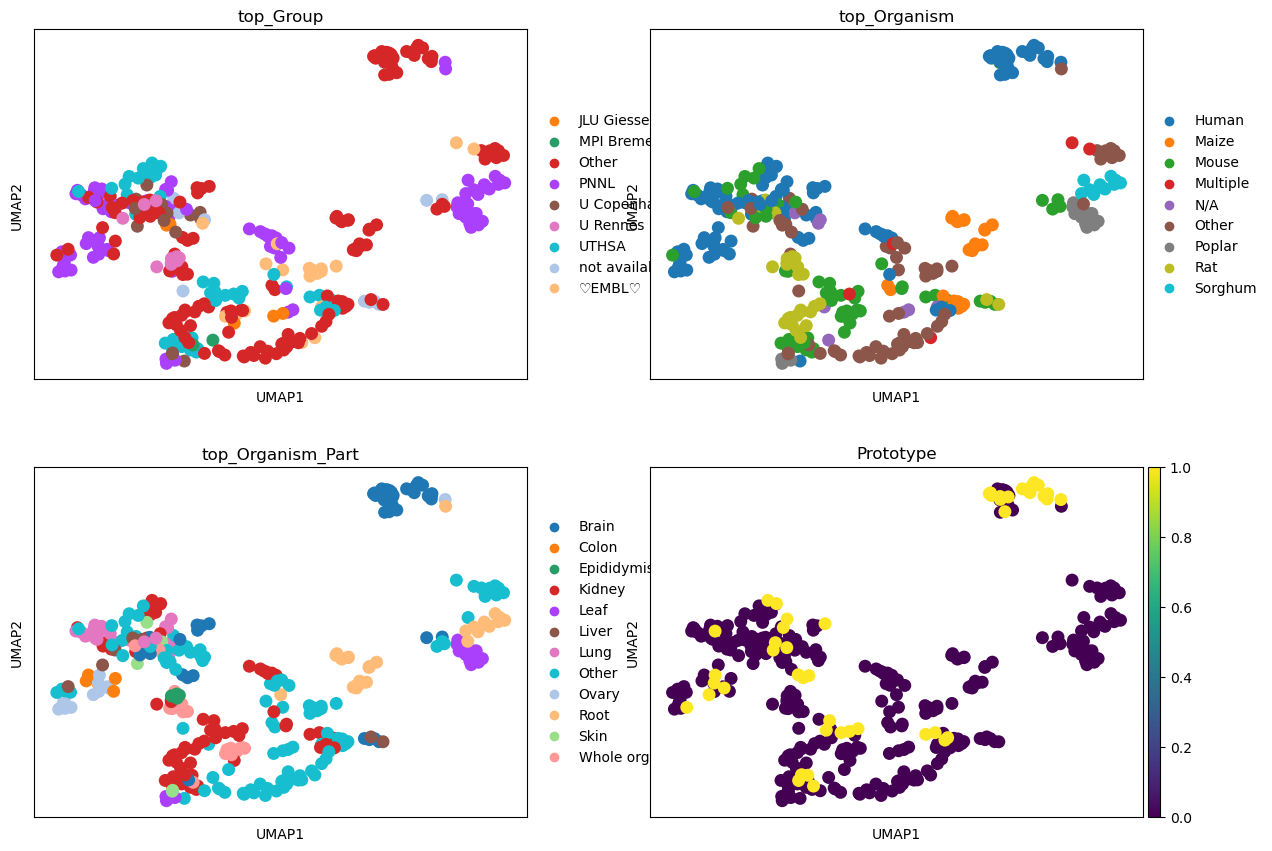

In [33]:
sc.pl.umap(adata_pos_met_matrix, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'Prototype'], 
           ncols=2)

## Lipids

### MZ range

In [34]:
adata_pos_lip = adata_pos[:,adata_pos.var['mass'] <= 900]
adata_pos_lip = adata_pos_lip[:,adata_pos_lip.var['mass'] >= 600]

sc.pp.filter_genes(adata_pos_lip, min_cells=100) # 200
sc.pp.filter_cells(adata_pos_lip, min_genes=20)
#sc.pp.normalize_total(adata_pos_met, target_sum=1e4)

sc.pp.pca(adata_pos_lip)
sc.pp.neighbors(adata_pos_lip, metric='cosine')
sc.tl.leiden(adata_pos_lip)
sc.tl.umap(adata_pos_lip)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


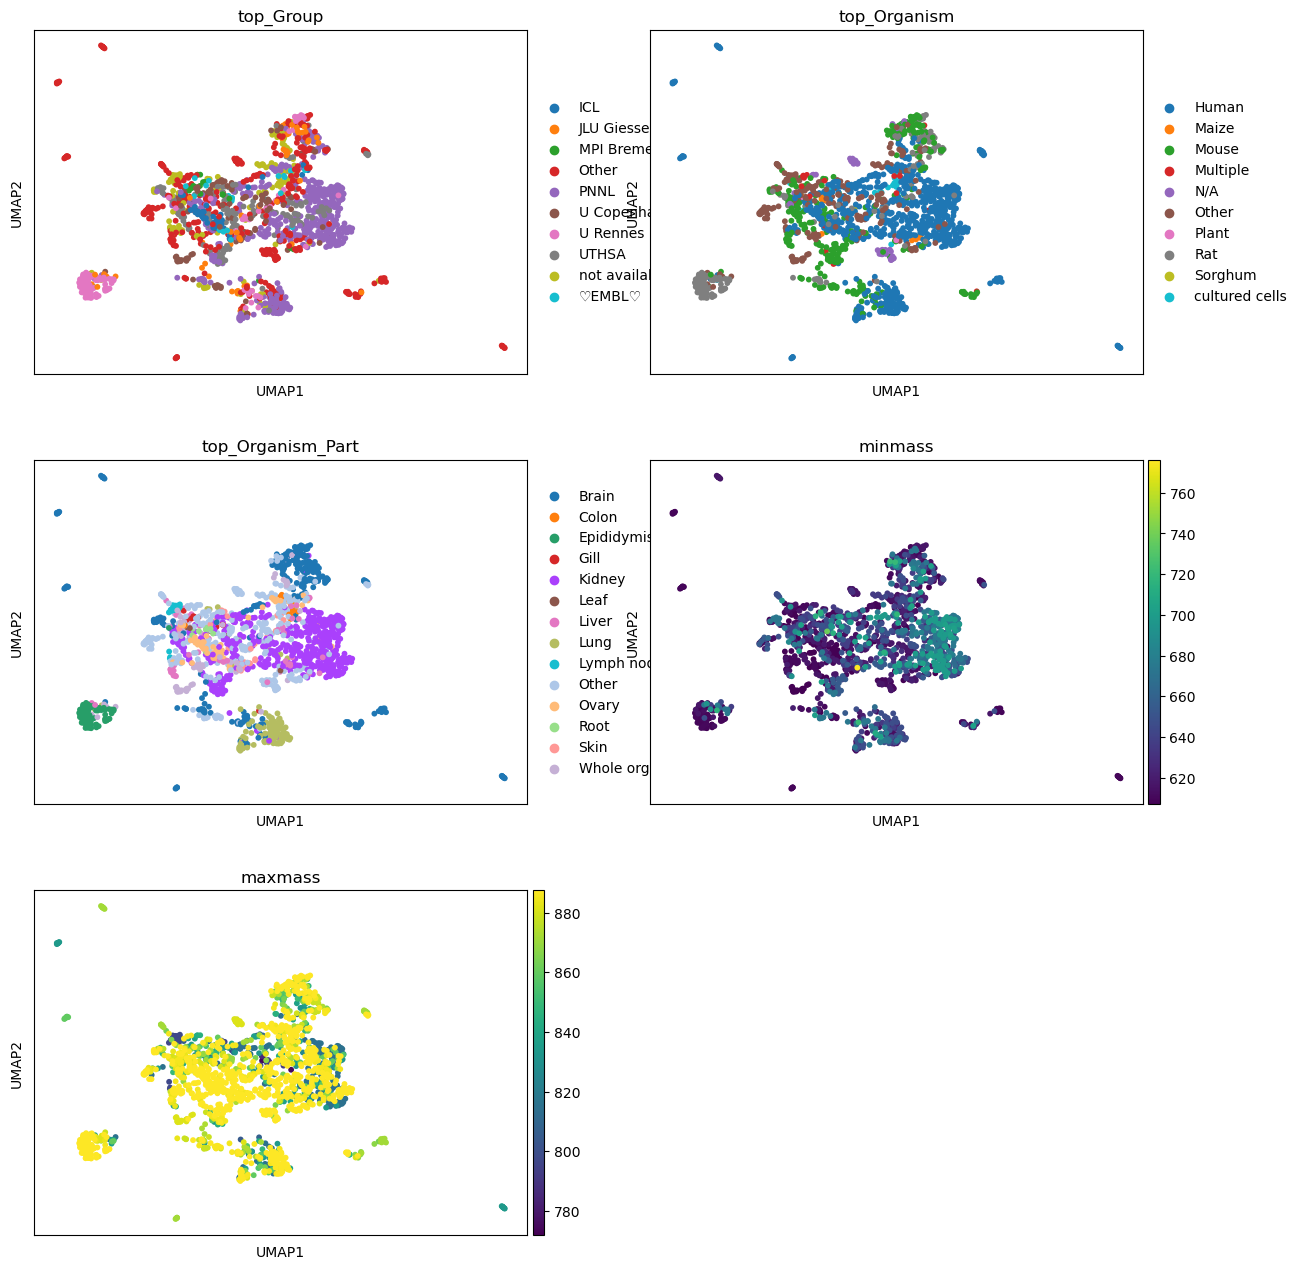

In [35]:
utils.update_minmax_mass(adata_pos_lip)
sc.pl.umap(adata_pos_lip, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

In [36]:
adata_pos_lip

AnnData object with n_obs × n_vars = 1700 × 358
    obs: 'Organism', 'Condition', 'Organism_Part', 'Polarity', 'maldi_matrix', 'Group', 'mzmin', 'mzmax', 'Analyzer', 'Ionisation_Source', 'top_Organism', 'top_Condition', 'top_Organism_Part', 'top_Polarity', 'top_maldi_matrix', 'top_Group', 'n_genes', 'leiden', 'minmass', 'maxmass'
    var: 'n_cells', 'mass'
    uns: 'neighbors', 'umap', 'pca', 'leiden', 'top_Group_colors', 'top_Organism_colors', 'top_Organism_Part_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### Matrix

<AxesSubplot: xlabel='top_maldi_matrix', ylabel='count'>

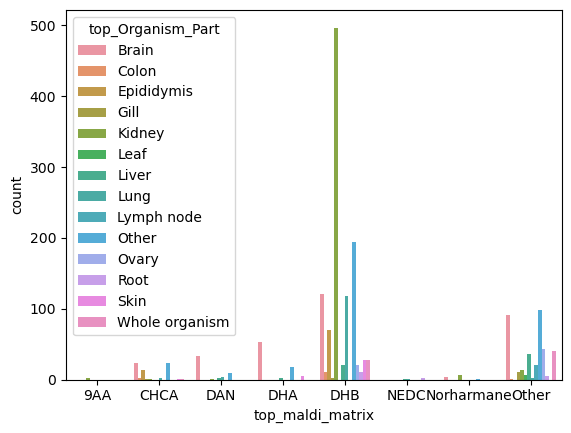

In [37]:
sns.countplot(data=adata_pos_lip.obs, x='top_maldi_matrix', hue='top_Organism_Part')

In [38]:
adata_pos_lip_matrix = adata_pos_lip[adata_pos_lip.obs['top_maldi_matrix']=='DHB',:]

sc.pp.pca(adata_pos_lip_matrix)
sc.pp.neighbors(adata_pos_lip_matrix, metric='cosine')
sc.tl.leiden(adata_pos_lip_matrix)
sc.tl.umap(adata_pos_lip_matrix)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


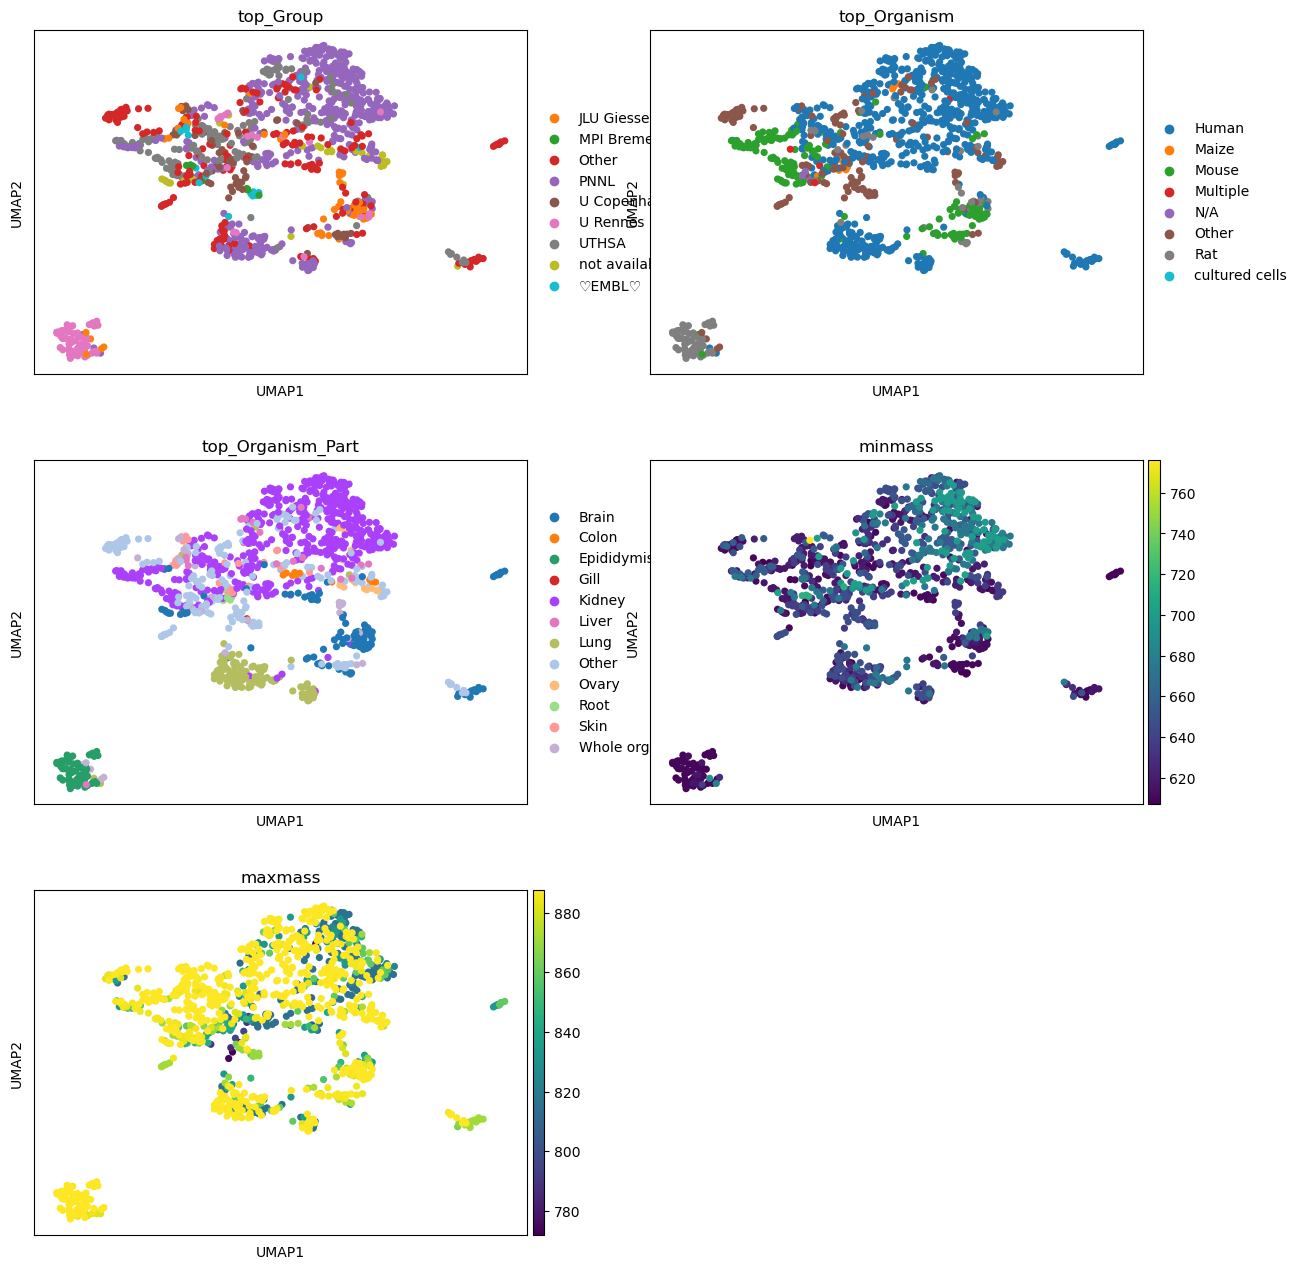

In [39]:
utils.update_minmax_mass(adata_pos_lip_matrix)
sc.pl.umap(adata_pos_lip_matrix, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

In [40]:
adata_pos_lip_matrix

AnnData object with n_obs × n_vars = 1119 × 358
    obs: 'Organism', 'Condition', 'Organism_Part', 'Polarity', 'maldi_matrix', 'Group', 'mzmin', 'mzmax', 'Analyzer', 'Ionisation_Source', 'top_Organism', 'top_Condition', 'top_Organism_Part', 'top_Polarity', 'top_maldi_matrix', 'top_Group', 'n_genes', 'leiden', 'minmass', 'maxmass'
    var: 'n_cells', 'mass'
    uns: 'neighbors', 'umap', 'pca', 'leiden', 'top_Group_colors', 'top_Organism_colors', 'top_Organism_Part_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### Select tissues

In [41]:
adata_pos_lip_matrix.obs.Organism_Part.value_counts(ascending=False)

Kidney                   497
Brain                    121
Lung                     118
Epididymis                70
Whole organism            28
Skin                      27
Buccal mucosa             23
Ovary                     21
Thorax exoskeleton        21
Liver                     20
Colon                     11
Muscle                    11
Eye                       11
Seed                      11
Root                      10
spheroids                 10
Jejunum                    9
Agar growth                9
Cells                      9
Embryo                     8
Stem                       8
Stomach                    6
Other                      5
Sciatic nerve              5
tissue section             4
Dorsal root ganglion       4
Small intestine            4
Spinal Cord                3
Blood cells                2
Spleen                     2
Tumor                      2
Gill                       2
Bone                       2
Retina                     2
intestinal tra

In [42]:
# Tissues
tissue_list = ['Kidney', 'Brain', 'Lung', 'Ovary', 'Epididymis', 'Liver', 'Buccal mucosa']

adata_pos_lip_matrix_tissue = adata_pos_lip_matrix[adata_pos_lip_matrix.obs['Organism_Part'].isin(tissue_list), :]

#sc.pp.filter_genes(adata_pos_met_matrix_tissue, min_cells=5)

sc.pp.pca(adata_pos_lip_matrix_tissue)
sc.pp.neighbors(adata_pos_lip_matrix_tissue, metric='cosine')
sc.tl.leiden(adata_pos_lip_matrix_tissue)
sc.tl.umap(adata_pos_lip_matrix_tissue)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


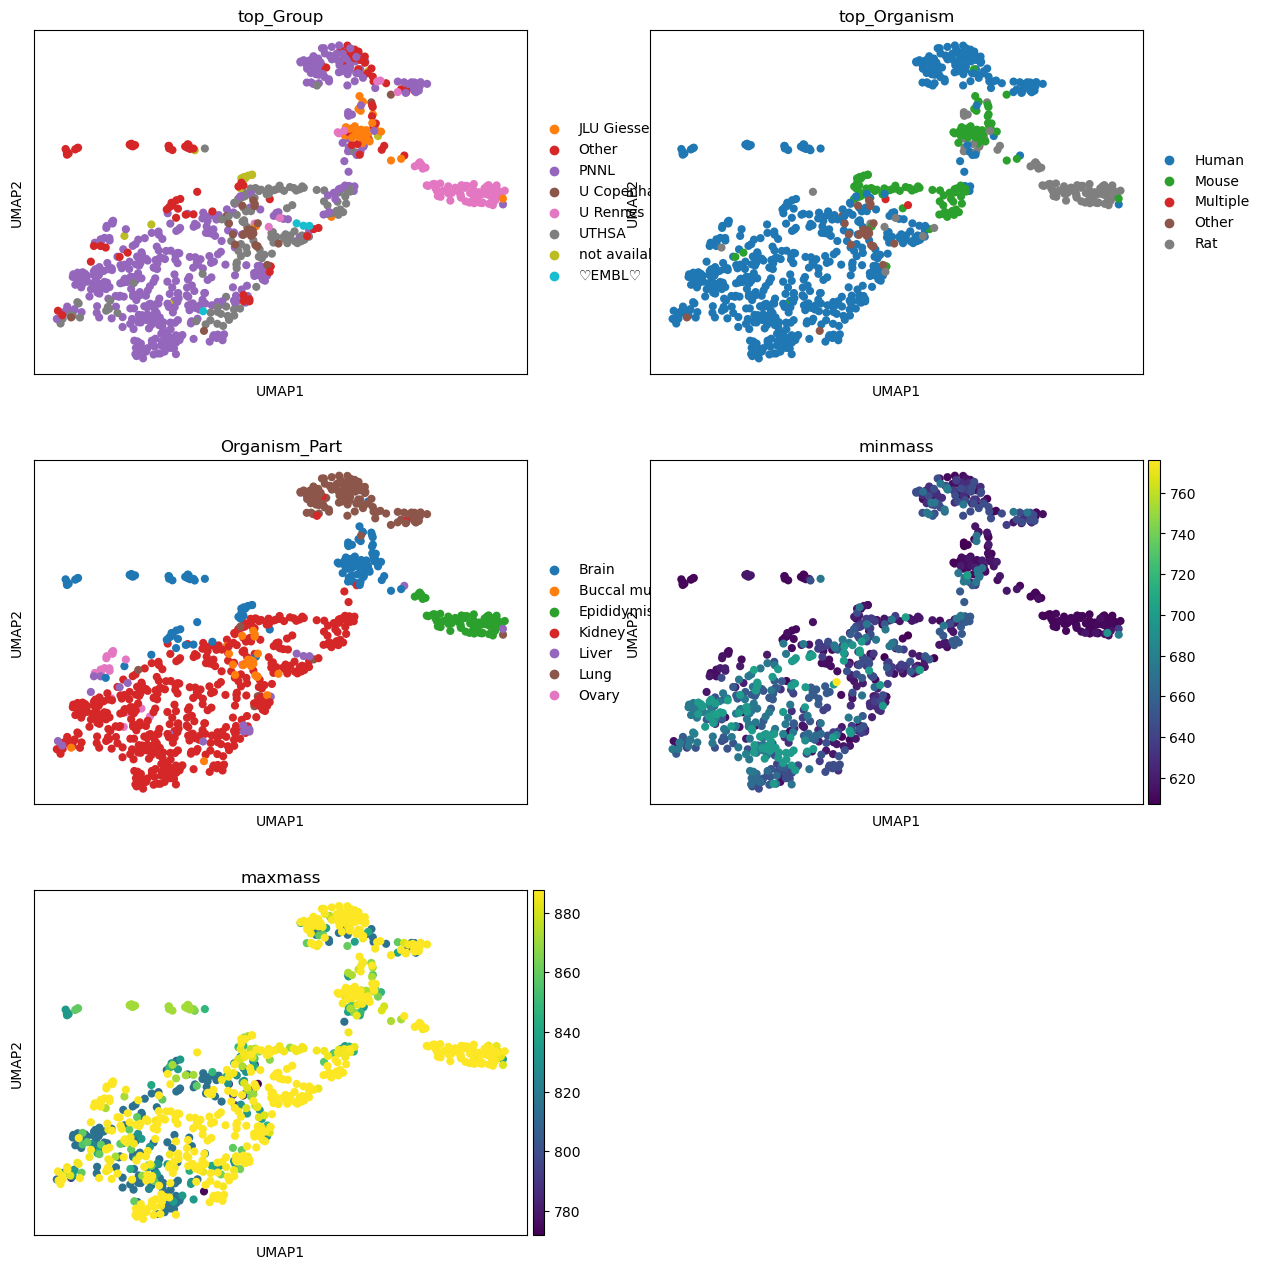

In [43]:
utils.update_minmax_mass(adata_pos_lip_matrix_tissue)
sc.pl.umap(adata_pos_lip_matrix_tissue, color=['top_Group', 'top_Organism', 'Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

In [44]:
adata_pos_lip_matrix_tissue

AnnData object with n_obs × n_vars = 870 × 358
    obs: 'Organism', 'Condition', 'Organism_Part', 'Polarity', 'maldi_matrix', 'Group', 'mzmin', 'mzmax', 'Analyzer', 'Ionisation_Source', 'top_Organism', 'top_Condition', 'top_Organism_Part', 'top_Polarity', 'top_maldi_matrix', 'top_Group', 'n_genes', 'leiden', 'minmass', 'maxmass'
    var: 'n_cells', 'mass'
    uns: 'neighbors', 'umap', 'pca', 'leiden', 'top_Group_colors', 'top_Organism_colors', 'top_Organism_Part_colors', 'Organism_Part_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### Tissue prototyping

In [45]:
pos_lip_mol_freq = {}
pos_lip_mol2_freq = {}
pos_lip_top_datasets = {}

mol_freq_cutoff = 0.1 # Initial: 0.1
top_ds_cutoff = 0.2 # Initial: 0.2

#### Kidney

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


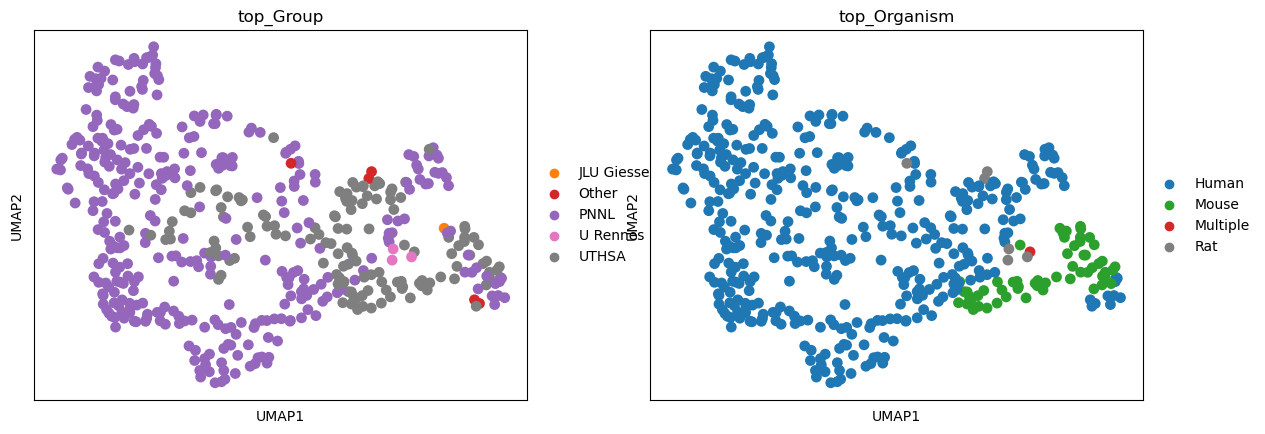

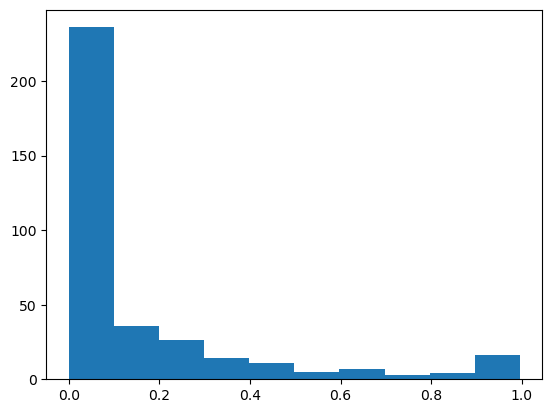

2022-12-07_02h13m50s    36
2022-12-07_02h13m20s    36
2022-12-07_02h10m45s    36
2022-12-07_02h09m41s    36
2022-12-07_02h08m52s    36
                        ..
2018-06-29_05h34m01s    36
2016-12-20_17h39m05s    35
2016-12-21_14h25m44s    35
2017-12-19_19h07m46s    35
2018-04-09_23h21m32s    35
Length: 111, dtype: int64
C44H86NO8P  -  ['PC(14:0/22:1(13Z))', 'PC(14:1(9Z)/22:0)', 'PC(16:0/20:1(11Z))', 'PC(16:1(9Z)/20:0)']
C46H82NO8P  -  ['PC(16:0/22:5(4Z,7Z,10Z,13Z,16Z))', 'PC(16:0/22:5(7Z,10Z,13Z,16Z,19Z))', 'PC(16:1(9Z)/22:4(7Z,10Z,13Z,16Z))', 'PC(18:0/20:5(5Z,8Z,11Z,14Z,17Z))']
C41H75O8P  -  ['PA(16:1(9Z)/22:2(13Z,16Z))', 'PA(18:0/20:3(5Z,8Z,11Z))', 'PA(18:2(9Z,12Z)/20:1(11Z))', 'PA(18:3(6Z,9Z,12Z)/20:0)']
C45H76NO7P  -  ['PE(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/P-18:1(11Z))', 'PE(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/P-18:1(9Z))', 'PE(P-18:1(11Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))', 'PE(P-18:1(9Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))']
C47H93N2O6P  -  ['SM(d18:1/24:1(15Z))', 'SM(d18:2(4E,14Z)/24:0)']
C42H80NO8P  - 

In [46]:
tissue = 'Kidney'
adat = adata_pos_lip_matrix_tissue[adata_pos_lip_matrix_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

utils.update_minmax_mass(adat)

sc.pl.umap(adat, color=['top_Group', 'top_Organism'], # , 'minmass', 'maxmass' 
           ncols=2)

pos_lip_mol2_freq[tissue], pos_lip_top_datasets[tissue] , pos_lip_mol_freq[tissue] = utils.tissue_prototyping(adat, 
                                                                                                              mol_freq_cutoff=mol_freq_cutoff, 
                                                                                                              top_ds_cutoff=top_ds_cutoff)
#pd.DataFrame(mol_freq2.index).to_csv(os.path.join(enrichment_dir, f'features_pos_{tissue}.csv'))

print(pos_lip_top_datasets[tissue])
utils.annotations_list(pos_lip_mol2_freq[tissue].index, hmdb_v4, n=4)

#### Brain

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


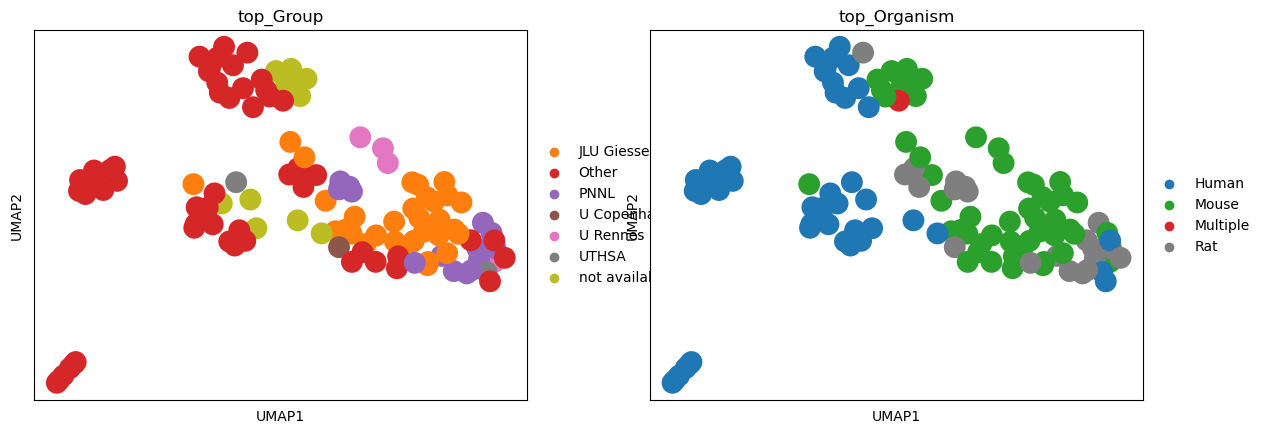

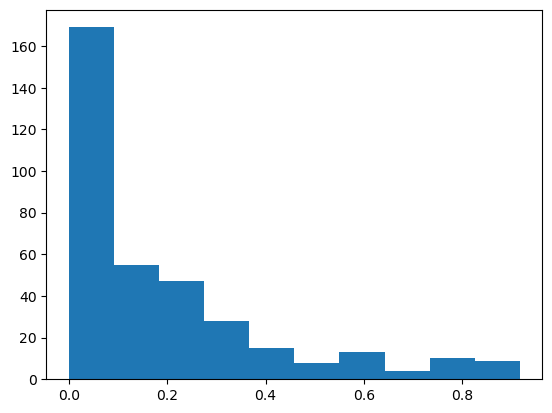

2022-08-24_00h20m06s    34
2022-08-23_23h48m59s    35
2022-07-19_19h29m24s    36
2022-05-31_10h46m34s    36
2022-05-31_10h27m17s    36
2022-05-30_20h44m19s    36
2022-05-30_20h07m49s    34
2022-01-31_09h08m54s    36
2022-01-31_08h54m51s    36
2021-12-01_13h25m50s    36
2021-11-11_11h49m37s    36
2021-11-04_14h12m55s    35
2021-11-04_11h38m42s    34
2018-08-01_14h26m17s    35
2018-08-01_14h25m56s    35
2018-08-01_14h25m21s    35
2018-08-01_14h24m55s    34
2018-08-01_14h24m33s    34
2018-08-01_14h24m14s    34
2018-08-01_14h21m22s    35
2018-08-01_14h21m02s    34
2018-08-01_14h20m46s    34
2018-08-01_14h20m30s    34
2017-02-24_13h22m14s    34
2016-09-21_16h06m56s    35
2017-02-17_14h41m43s    36
2017-02-17_14h56m37s    35
2016-09-21_16h06m55s    36
2017-06-09_07h12m31s    35
2017-06-13_10h42m55s    35
2017-06-20_11h57m55s    34
dtype: int64
C44H86NO8P  -  ['PC(14:0/22:1(13Z))', 'PC(14:1(9Z)/22:0)', 'PC(16:0/20:1(11Z))', 'PC(16:1(9Z)/20:0)']
C46H82NO8P  -  ['PC(16:0/22:5(4Z,7Z,10Z,13Z,16Z)

In [47]:
tissue = 'Brain'
adat = adata_pos_lip_matrix_tissue[adata_pos_lip_matrix_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

utils.update_minmax_mass(adat)

sc.pl.umap(adat, color=['top_Group', 'top_Organism'], # , 'minmass', 'maxmass' 
           ncols=2)

pos_lip_mol2_freq[tissue], pos_lip_top_datasets[tissue] , pos_lip_mol_freq[tissue] = utils.tissue_prototyping(adat, 
                                                                                                              mol_freq_cutoff=mol_freq_cutoff, 
                                                                                                              top_ds_cutoff=top_ds_cutoff)
#pd.DataFrame(mol_freq2.index).to_csv(os.path.join(enrichment_dir, f'features_pos_{tissue}.csv'))

print(pos_lip_top_datasets[tissue])
utils.annotations_list(pos_lip_mol2_freq[tissue].index, hmdb_v4, n=4)

#### Lung

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


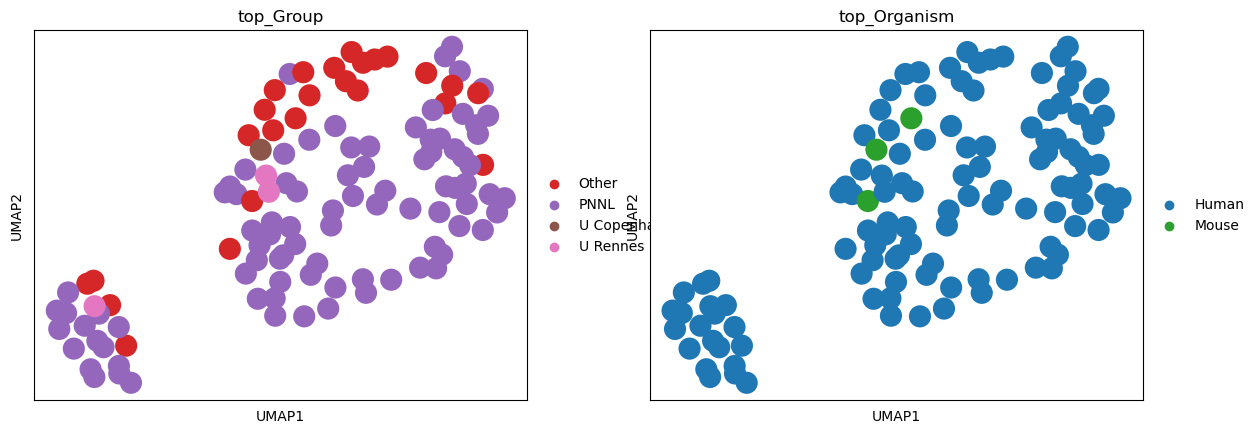

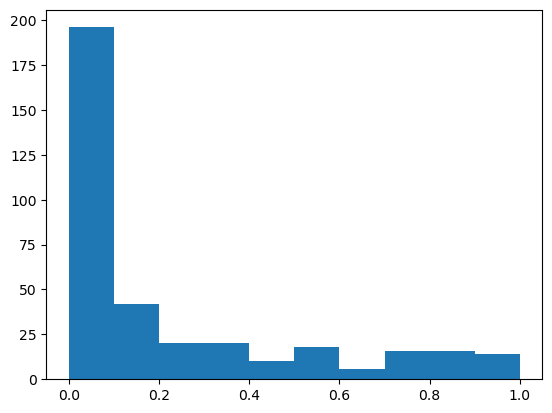

2023-01-25_03h20m26s    37
2022-12-01_19h18m05s    37
2022-12-01_19h18m26s    37
2022-11-02_16h29m10s    37
2022-11-02_16h26m42s    37
2022-10-27_22h05m48s    37
2022-10-27_22h05m18s    37
2022-10-17_20h30m37s    37
2022-10-17_20h29m14s    37
2022-10-17_20h24m34s    37
2022-09-24_00h16m25s    37
2022-09-24_00h14m50s    37
2022-09-24_00h13m14s    37
2022-09-24_00h10m42s    37
2021-10-11_21h07m40s    37
2021-10-11_19h38m30s    37
2021-10-11_19h06m59s    37
2021-10-11_18h34m31s    37
2021-09-24_22h15m05s    37
2021-08-16_23h52m40s    37
2021-08-17_00h06m31s    37
2021-08-16_23h37m34s    37
2021-08-16_23h19m04s    37
2021-08-16_23h18m11s    37
2021-08-16_23h19m40s    37
2021-08-09_18h51m36s    37
2021-08-09_18h39m16s    37
2021-08-09_18h40m08s    37
2021-08-09_18h34m16s    37
2021-07-14_18h53m01s    37
2021-07-14_18h51m25s    37
2021-05-19_20h11m50s    37
2021-05-19_20h10m58s    37
2021-05-19_20h09m03s    37
2021-05-11_19h43m45s    37
2020-12-22_23h17m29s    37
2020-12-22_23h09m43s    37
2

In [48]:
tissue = 'Lung'
adat = adata_pos_lip_matrix_tissue[adata_pos_lip_matrix_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

utils.update_minmax_mass(adat)

sc.pl.umap(adat, color=['top_Group', 'top_Organism'], # , 'minmass', 'maxmass' 
           ncols=2)

pos_lip_mol2_freq[tissue], pos_lip_top_datasets[tissue] , pos_lip_mol_freq[tissue] = utils.tissue_prototyping(adat, 
                                                                                                              mol_freq_cutoff=mol_freq_cutoff, 
                                                                                                              top_ds_cutoff=top_ds_cutoff)
#pd.DataFrame(mol_freq2.index).to_csv(os.path.join(enrichment_dir, f'features_pos_{tissue}.csv'))

print(pos_lip_top_datasets[tissue])
utils.annotations_list(pos_lip_mol2_freq[tissue].index, hmdb_v4, n=4)

#### Ovary

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


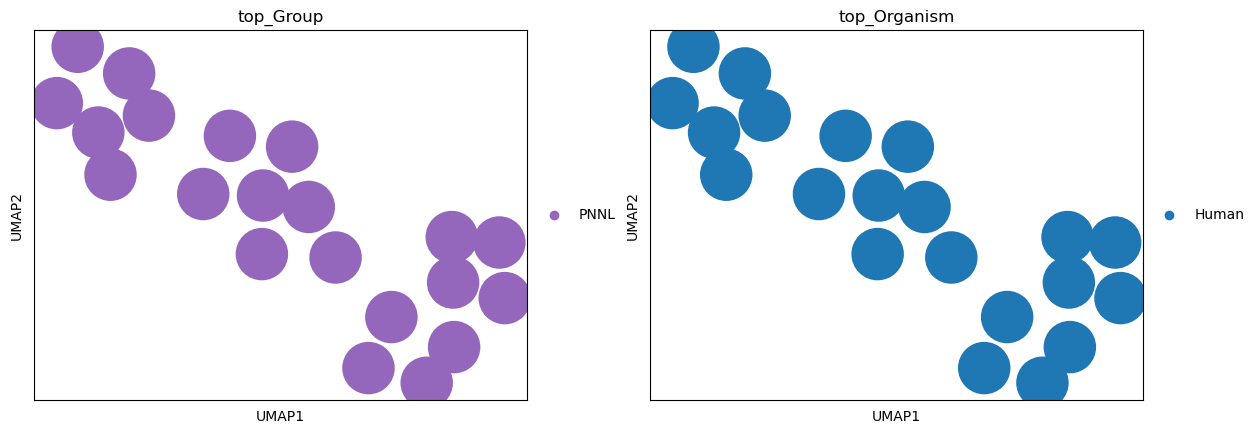

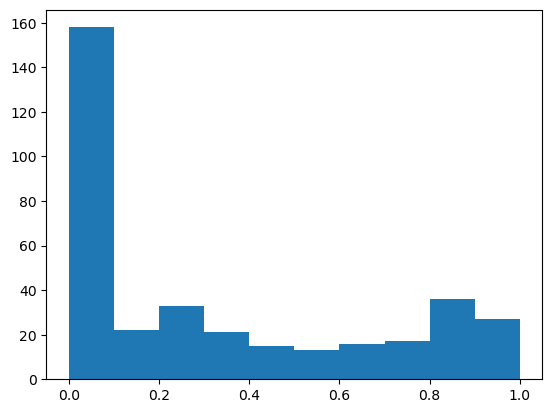

2022-04-05_01h59m18s    53
2022-04-04_22h54m13s    53
2022-03-08_20h56m36s    53
2022-03-08_08h31m54s    53
2021-11-19_23h25m16s    53
2021-11-19_23h24m54s    53
2021-11-19_23h21m55s    53
2021-11-18_23h18m10s    53
2021-11-18_23h17m02s    53
2021-11-18_23h17m50s    53
2021-11-18_23h17m34s    53
2021-11-18_20h09m21s    53
2021-11-18_20h09m36s    53
2021-11-18_20h09m55s    53
dtype: int64
C44H86NO8P  -  ['PC(14:0/22:1(13Z))', 'PC(14:1(9Z)/22:0)', 'PC(16:0/20:1(11Z))', 'PC(16:1(9Z)/20:0)']
C46H82NO8P  -  ['PC(16:0/22:5(4Z,7Z,10Z,13Z,16Z))', 'PC(16:0/22:5(7Z,10Z,13Z,16Z,19Z))', 'PC(16:1(9Z)/22:4(7Z,10Z,13Z,16Z))', 'PC(18:0/20:5(5Z,8Z,11Z,14Z,17Z))']
C41H75O8P  -  ['PA(16:1(9Z)/22:2(13Z,16Z))', 'PA(18:0/20:3(5Z,8Z,11Z))', 'PA(18:2(9Z,12Z)/20:1(11Z))', 'PA(18:3(6Z,9Z,12Z)/20:0)']
C39H81N2O6P  -  ['SM(d18:0/16:0)']
C45H76NO7P  -  ['PE(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/P-18:1(11Z))', 'PE(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/P-18:1(9Z))', 'PE(P-18:1(11Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))', 'PE(P-18:1(9Z)/22:6(4Z,

In [49]:
tissue = 'Ovary'
adat = adata_pos_lip_matrix_tissue[adata_pos_lip_matrix_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

utils.update_minmax_mass(adat)

sc.pl.umap(adat, color=['top_Group', 'top_Organism'], # , 'minmass', 'maxmass' 
           ncols=2)

pos_lip_mol2_freq[tissue], pos_lip_top_datasets[tissue] , pos_lip_mol_freq[tissue] = utils.tissue_prototyping(adat, 
                                                                                                              mol_freq_cutoff=mol_freq_cutoff, 
                                                                                                              top_ds_cutoff=top_ds_cutoff)
#pd.DataFrame(mol_freq2.index).to_csv(os.path.join(enrichment_dir, f'features_pos_{tissue}.csv'))

print(pos_lip_top_datasets[tissue])
utils.annotations_list(pos_lip_mol2_freq[tissue].index, hmdb_v4, n=4)

#### Epididymis

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


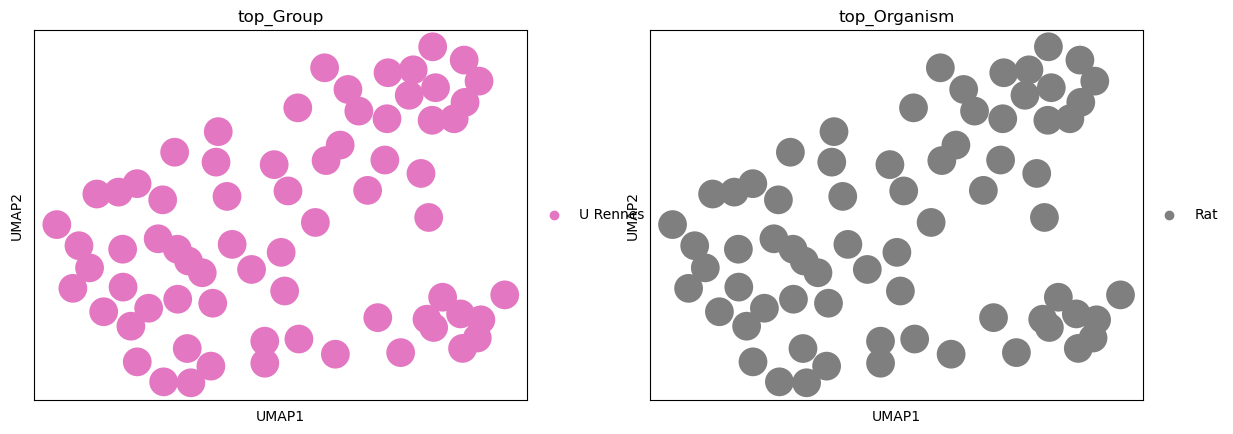

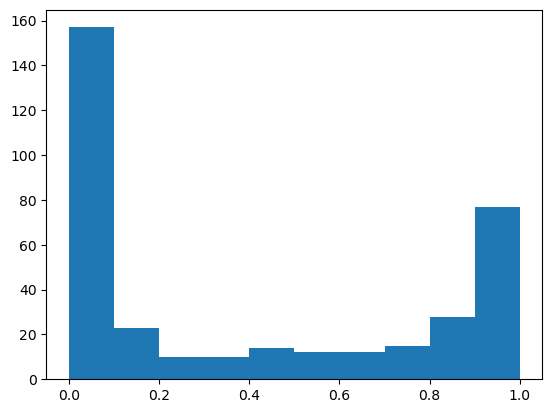

2020-02-17_15h07m36s    42
2020-02-14_16h45m44s    42
2017-07-18_10h04m10s    42
2017-07-18_10h11m20s    42
2017-07-18_10h11m46s    42
                        ..
2017-11-27_16h06m20s    42
2017-11-27_16h07m06s    42
2017-12-11_15h06m45s    42
2017-12-11_15h07m13s    42
2017-12-11_15h07m56s    42
Length: 64, dtype: int64
C44H88NO7P  -  ['PC(18:0/P-18:0)', 'PC(20:0/P-16:0)', 'PC(P-16:0/20:0)', 'PC(P-18:0/18:0)']
C46H88NO7P  -  ['PC(20:1(11Z)/P-18:1(11Z))', 'PC(20:1(11Z)/P-18:1(9Z))', 'PC(20:2(11Z,14Z)/P-18:0)', 'PC(22:2(13Z,16Z)/P-16:0)']
C44H86NO8P  -  ['PC(14:0/22:1(13Z))', 'PC(14:1(9Z)/22:0)', 'PC(16:0/20:1(11Z))', 'PC(16:1(9Z)/20:0)']
C46H82NO8P  -  ['PC(16:0/22:5(4Z,7Z,10Z,13Z,16Z))', 'PC(16:0/22:5(7Z,10Z,13Z,16Z,19Z))', 'PC(16:1(9Z)/22:4(7Z,10Z,13Z,16Z))', 'PC(18:0/20:5(5Z,8Z,11Z,14Z,17Z))']
C41H75O8P  -  ['PA(16:1(9Z)/22:2(13Z,16Z))', 'PA(18:0/20:3(5Z,8Z,11Z))', 'PA(18:2(9Z,12Z)/20:1(11Z))', 'PA(18:3(6Z,9Z,12Z)/20:0)']
C47H93N2O6P  -  ['SM(d18:1/24:1(15Z))', 'SM(d18:2(4E,14Z)/24:0

In [50]:
tissue = 'Epididymis'
adat = adata_pos_lip_matrix_tissue[adata_pos_lip_matrix_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

utils.update_minmax_mass(adat)

sc.pl.umap(adat, color=['top_Group', 'top_Organism'], # , 'minmass', 'maxmass' 
           ncols=2)

pos_lip_mol2_freq[tissue], pos_lip_top_datasets[tissue] , pos_lip_mol_freq[tissue] = utils.tissue_prototyping(adat, 
                                                                                                              mol_freq_cutoff=mol_freq_cutoff, 
                                                                                                              top_ds_cutoff=top_ds_cutoff)
#pd.DataFrame(mol_freq2.index).to_csv(os.path.join(enrichment_dir, f'features_pos_{tissue}.csv'))

print(pos_lip_top_datasets[tissue])
utils.annotations_list(pos_lip_mol2_freq[tissue].index, hmdb_v4, n=4)

#### Liver

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


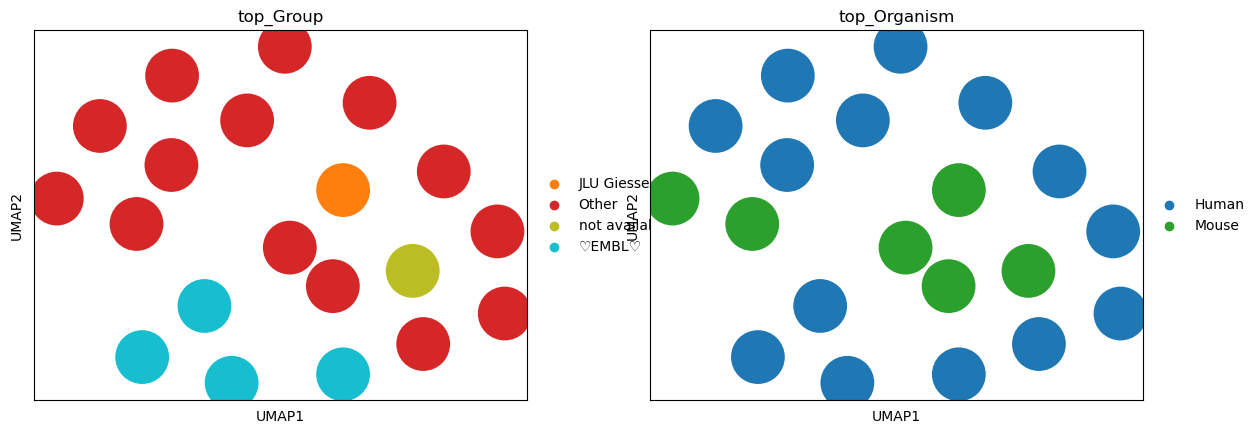

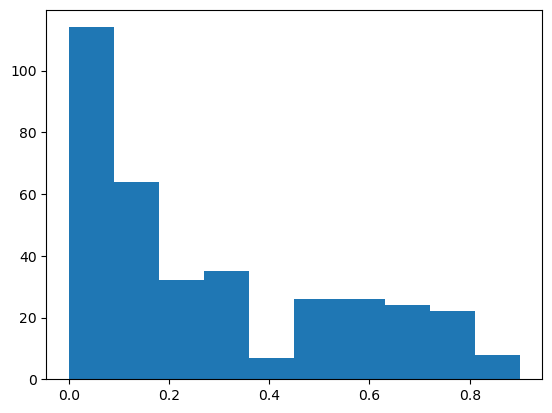

2017-09-07_15h09m00s    42
2017-09-07_15h12m25s    42
2017-08-22_15h16m21s    42
2017-08-16_15h52m56s    42
2017-08-16_15h51m46s    42
2017-08-11_12h31m52s    42
2017-08-11_12h30m20s    42
2017-08-07_13h21m54s    42
2017-08-07_13h19m42s    42
dtype: int64
C51H94O6  -  ['TG(16:0/16:1(9Z)/16:1(9Z))', 'TG(16:0/14:0/18:2(9Z,12Z))', 'TG(16:1(9Z)/14:0/18:1(11Z))', 'TG(16:1(9Z)/14:0/18:1(9Z))']
C57H98O6  -  ['TG(16:0/18:2(9Z,12Z)/20:4(5Z,8Z,11Z,14Z))', 'TG(16:1(9Z)/18:1(9Z)/20:4(5Z,8Z,11Z,14Z))', 'TG(18:2(9Z,12Z)/18:2(9Z,12Z)/18:2(9Z,12Z))', 'TG(16:0/16:0/22:6(4Z,7Z,10Z,13Z,16Z,19Z))']
C44H86NO8P  -  ['PC(14:0/22:1(13Z))', 'PC(14:1(9Z)/22:0)', 'PC(16:0/20:1(11Z))', 'PC(16:1(9Z)/20:0)']
C46H82NO8P  -  ['PC(16:0/22:5(4Z,7Z,10Z,13Z,16Z))', 'PC(16:0/22:5(7Z,10Z,13Z,16Z,19Z))', 'PC(16:1(9Z)/22:4(7Z,10Z,13Z,16Z))', 'PC(18:0/20:5(5Z,8Z,11Z,14Z,17Z))']
C41H75O8P  -  ['PA(16:1(9Z)/22:2(13Z,16Z))', 'PA(18:0/20:3(5Z,8Z,11Z))', 'PA(18:2(9Z,12Z)/20:1(11Z))', 'PA(18:3(6Z,9Z,12Z)/20:0)']
C39H81N2O6P  -  ['S

In [51]:
tissue = 'Liver'
adat = adata_pos_lip_matrix_tissue[adata_pos_lip_matrix_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

utils.update_minmax_mass(adat)

sc.pl.umap(adat, color=['top_Group', 'top_Organism'], # , 'minmass', 'maxmass' 
           ncols=2)

pos_lip_mol2_freq[tissue], pos_lip_top_datasets[tissue] , pos_lip_mol_freq[tissue] = utils.tissue_prototyping(adat, 
                                                                                                              mol_freq_cutoff=mol_freq_cutoff, 
                                                                                                              top_ds_cutoff=top_ds_cutoff)
#pd.DataFrame(mol_freq2.index).to_csv(os.path.join(enrichment_dir, f'features_pos_{tissue}.csv'))

print(pos_lip_top_datasets[tissue])
utils.annotations_list(pos_lip_mol2_freq[tissue].index, hmdb_v4, n=4)

#### Buccal mucosa

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


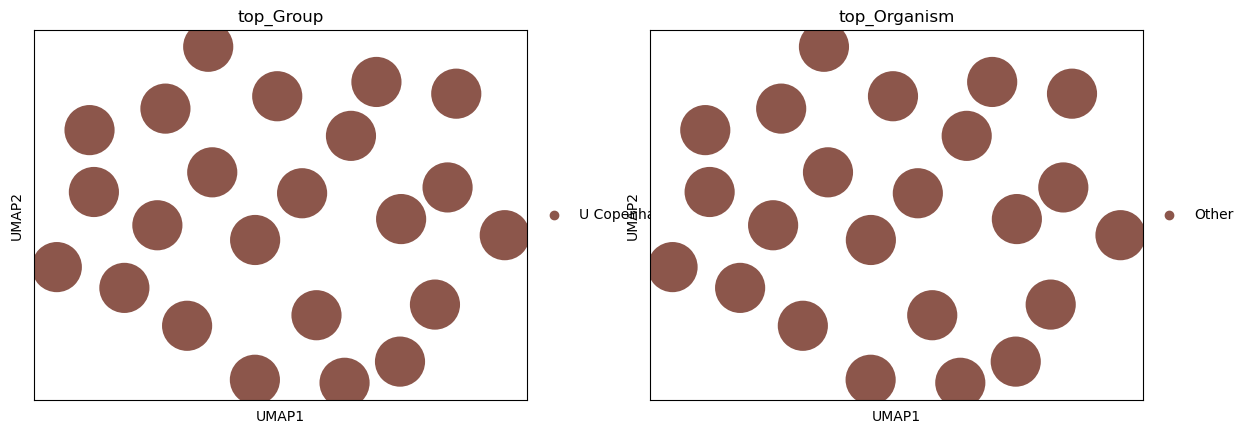

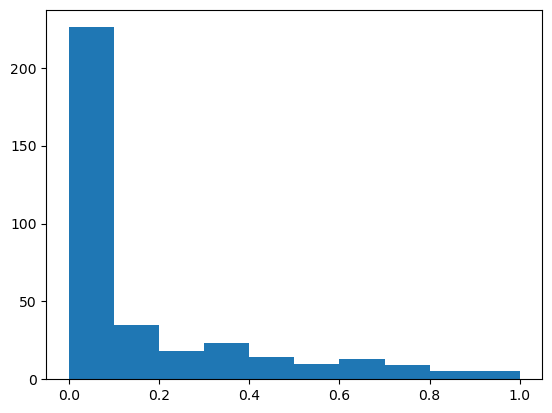

2017-02-23_10h06m16s    36
2017-08-14_08h34m24s    36
2017-11-03_16h29m32s    36
2018-02-23_14h12m27s    35
2018-03-16_10h42m21s    35
dtype: int64
C38H78NO7P  -  ['PC(O-14:0/16:0)']
C44H86NO8P  -  ['PC(14:0/22:1(13Z))', 'PC(14:1(9Z)/22:0)', 'PC(16:0/20:1(11Z))', 'PC(16:1(9Z)/20:0)']
C41H75O8P  -  ['PA(16:1(9Z)/22:2(13Z,16Z))', 'PA(18:0/20:3(5Z,8Z,11Z))', 'PA(18:2(9Z,12Z)/20:1(11Z))', 'PA(18:3(6Z,9Z,12Z)/20:0)']
C39H81N2O6P  -  ['SM(d18:0/16:0)']
C45H76NO7P  -  ['PE(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/P-18:1(11Z))', 'PE(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/P-18:1(9Z))', 'PE(P-18:1(11Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))', 'PE(P-18:1(9Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))']
C39H69O8P  -  ['1,2-Di-(9Z,12Z-octadecadienoyl)-sn-glycero-3-phosphate', 'PA(14:0/22:4(7Z,10Z,13Z,16Z))', 'PA(16:0/20:4(5Z,8Z,11Z,14Z))', 'PA(16:1(9Z)/20:3(5Z,8Z,11Z))']
C42H80NO8P  -  ['PC(14:0/20:2(11Z,14Z))', 'PC(14:1(9Z)/20:1(11Z))', 'PC(16:0/18:2(9Z,12Z))', 'PC(16:1(9Z)/18:1(11Z))']
C39H73O8P  -  ['PA(18:0/18:2(9Z,12Z))', 'PA(18:1(11Z)/18:1

In [52]:
tissue = 'Buccal mucosa'
adat = adata_pos_lip_matrix_tissue[adata_pos_lip_matrix_tissue.obs['Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

utils.update_minmax_mass(adat)

sc.pl.umap(adat, color=['top_Group', 'top_Organism'], # , 'minmass', 'maxmass' 
           ncols=2)

pos_lip_mol2_freq[tissue], pos_lip_top_datasets[tissue] , pos_lip_mol_freq[tissue] = utils.tissue_prototyping(adat, 
                                                                                                              mol_freq_cutoff=mol_freq_cutoff, 
                                                                                                              top_ds_cutoff=top_ds_cutoff)
#pd.DataFrame(mol_freq2.index).to_csv(os.path.join(enrichment_dir, f'features_pos_{tissue}.csv'))

print(pos_lip_top_datasets[tissue])
utils.annotations_list(pos_lip_mol2_freq[tissue].index, hmdb_v4, n=4)

### Tissue similarity

In [53]:
freq_tab = pd.DataFrame(pos_lip_mol2_freq).transpose()
freq_tab[freq_tab.isna()] = 0
sim_tab = pd.DataFrame(pairwise_kernels(freq_tab, metric='cosine'), index=freq_tab.index, columns=freq_tab.index)

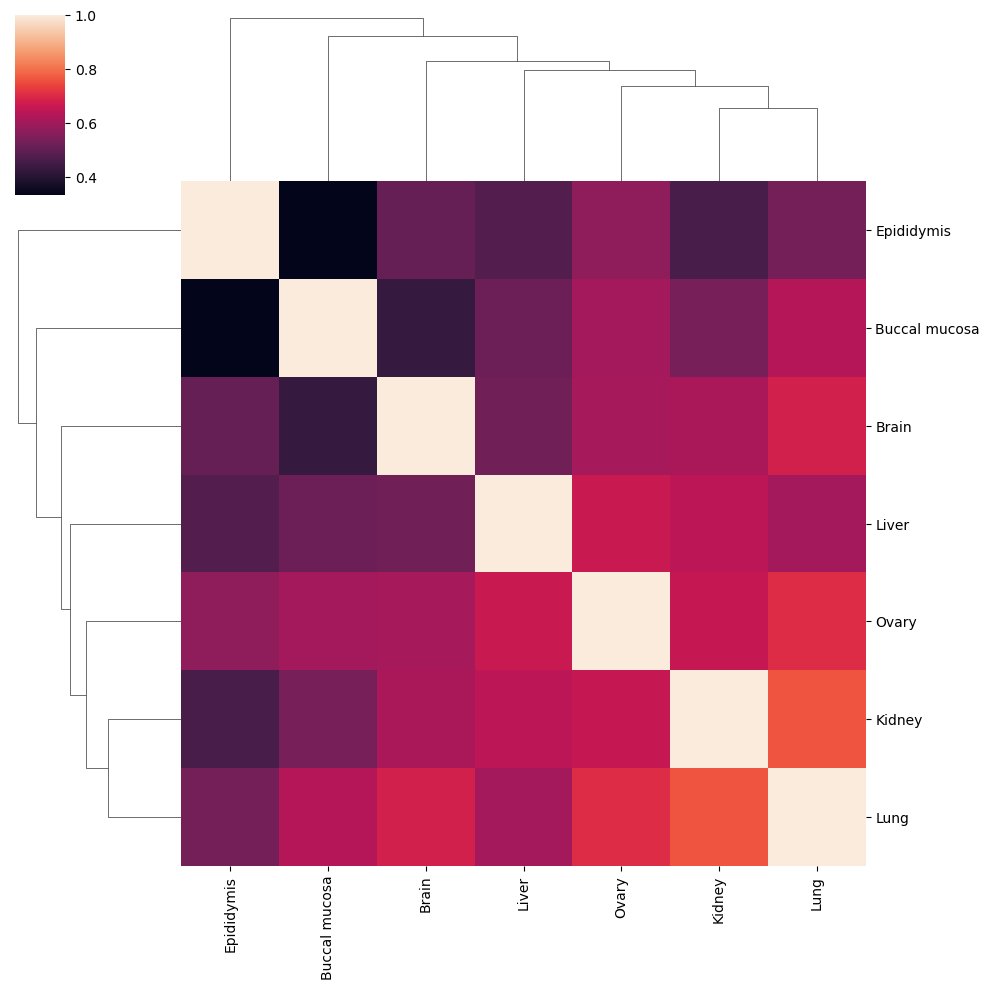

In [54]:
sns.clustermap(sim_tab)

In [55]:
tmp_sim_tab = sim_tab.copy()
tmp_sim_tab[tmp_sim_tab<0.65] = 0
g = nx.from_pandas_adjacency(tmp_sim_tab)
g.remove_edges_from(nx.selfloop_edges(g))

In [56]:
pos = nx.spring_layout(g, k=1.3)

/tmp/ipykernel_76/3078639686.py:9: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


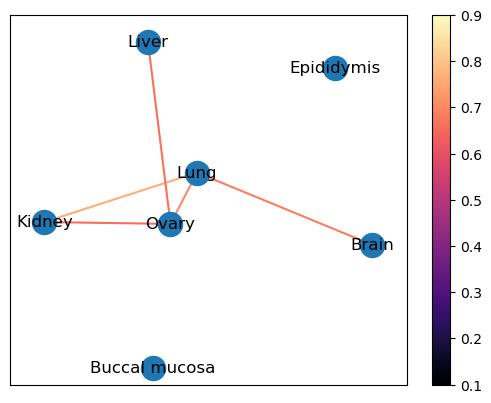

In [57]:
cm = plt.get_cmap('magma')
edge_weights = [d['weight'] for u, v, d in g.edges(data=True)]
vmin=0.1
vmax=0.9
nx.draw_networkx_edges(g, pos=pos, edge_color=edge_weights, edge_cmap=cm, width=1.5, edge_vmin=vmin, edge_vmax=vmax)
nx.draw_networkx_nodes(g, pos=pos)
nx.draw_networkx_labels(g, pos=pos)
sm = plt.cm.ScalarMappable(cmap=cm, norm=plt.Normalize(vmin=vmin, vmax=vmax))
plt.colorbar(sm)

plt.show()

In [68]:
adata_pos_lip_matrix_tissue.obs['Organism_Part'].value_counts()

Kidney           497
Brain            121
Lung             118
Epididymis        70
Buccal mucosa     23
Ovary             21
Liver             20
Name: Organism_Part, dtype: int64

### Prototypes on UMAP

In [59]:
prot_list = utils.flatten([list(v.index) for v in pos_lip_top_datasets.values()])
adata_pos_lip_matrix.obs['Prototype'] = adata_pos_lip_matrix.obs.index.isin(prot_list).astype('float64')

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


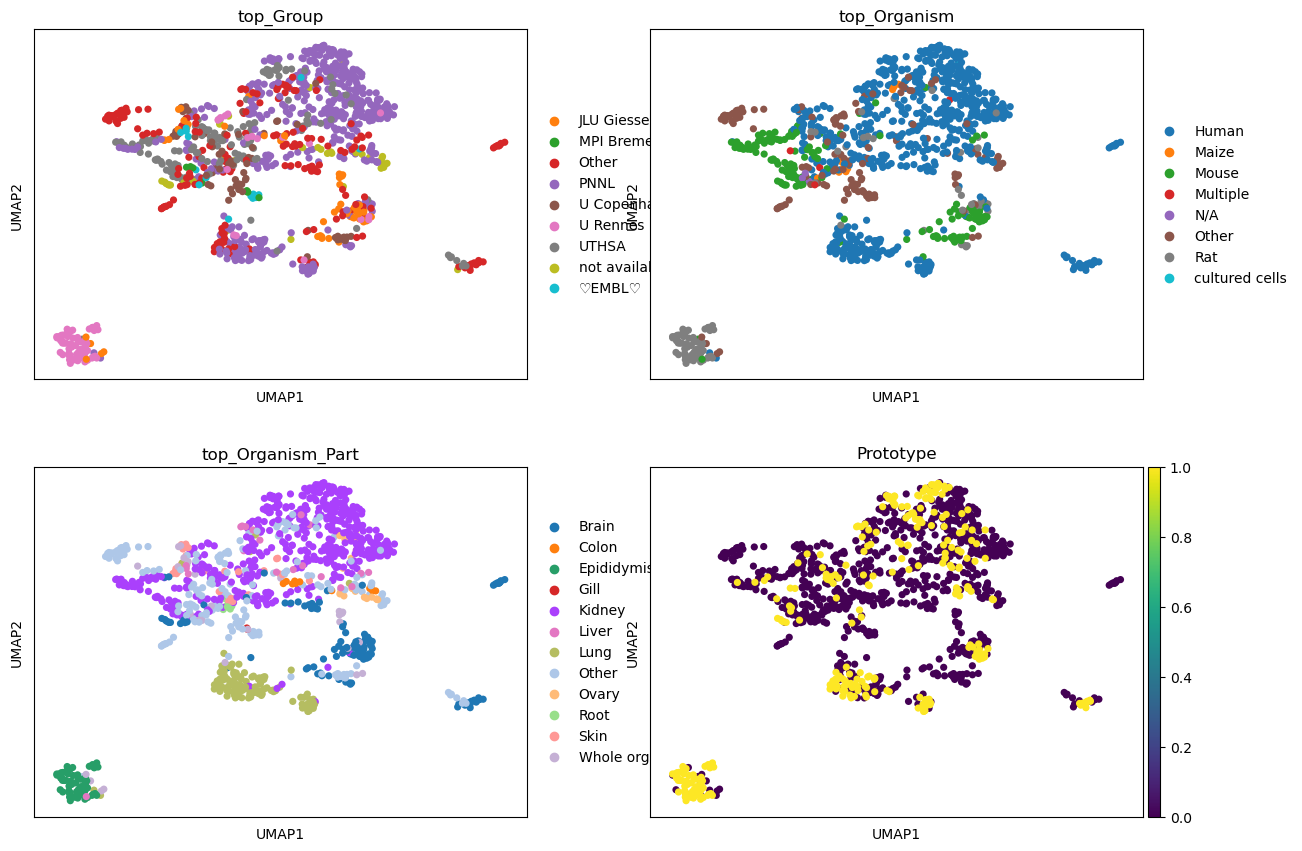

In [60]:
sc.pl.umap(adata_pos_lip_matrix, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'Prototype'], 
           ncols=2)

# Negative

In [145]:
adata_neg = adata[adata.obs['Polarity']=='Negative',:]

sc.pp.filter_genes(adata_neg, min_cells=100) # 200
sc.pp.filter_cells(adata_neg, min_genes=20) # 50
sc.pp.normalize_total(adata_neg, target_sum=1e4)

#sc.pp.neighbors(adata_pos, metric='cosine')
#sc.tl.leiden(adata_pos)
#sc.tl.umap(adata_pos)

adata_neg.var['mass'] = [Formula(x).mass for x in adata_neg.var.index.values]

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [149]:
adata_neg

AnnData object with n_obs × n_vars = 2074 × 731
    obs: 'Organism', 'Condition', 'Organism_Part', 'Polarity', 'maldi_matrix', 'Group', 'mzmin', 'mzmax', 'Analyzer', 'Ionisation_Source', 'top_Organism', 'top_Condition', 'top_Organism_Part', 'top_Polarity', 'top_maldi_matrix', 'top_Group', 'n_genes'
    var: 'n_cells', 'mass'
    uns: 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

## Metabolites

### MZ range

In [146]:
adata_neg_met = adata_neg[:,adata_neg.var['mass'] <= 350]
adata_neg_met = adata_neg_met[:,adata_neg_met.var['mass'] >= 100]

sc.pp.filter_genes(adata_neg_met, min_cells=100) # 200
sc.pp.filter_cells(adata_neg_met, min_genes=20)
#sc.pp.normalize_total(adata_pos_met, target_sum=1e4)

sc.pp.pca(adata_neg_met)
sc.pp.neighbors(adata_neg_met, metric='cosine')
sc.tl.leiden(adata_neg_met)
sc.tl.umap(adata_neg_met)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


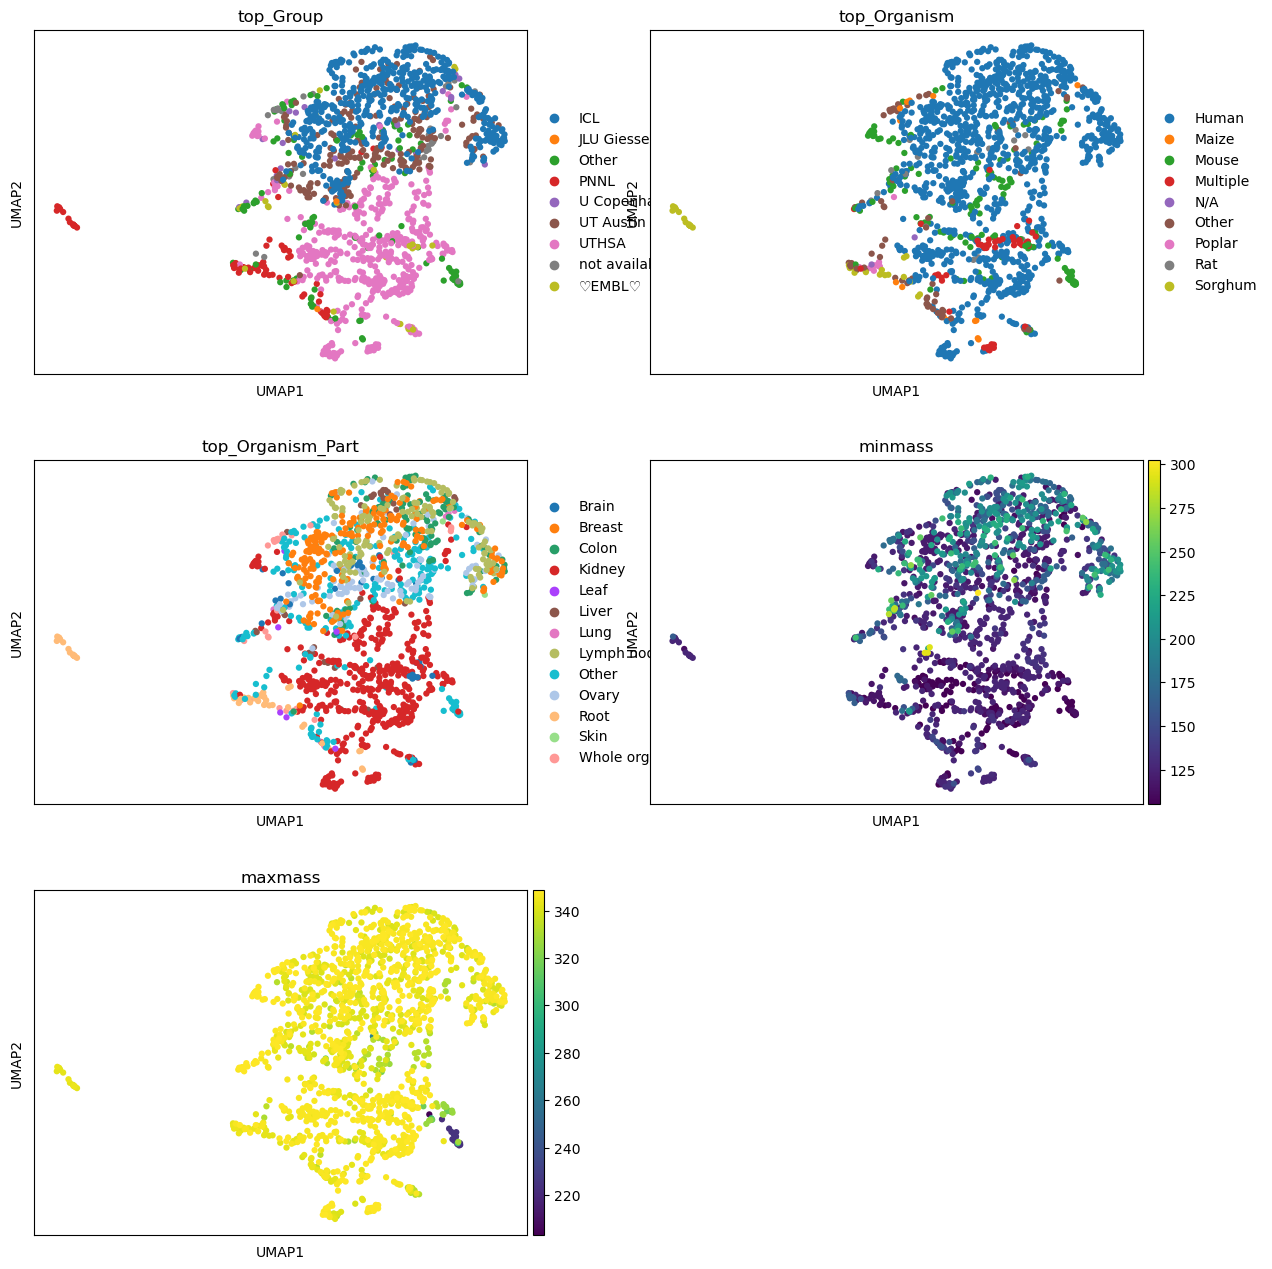

In [147]:
utils.update_minmax_mass(adata_neg_met)
sc.pl.umap(adata_neg_met, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

In [148]:
adata_neg_met

AnnData object with n_obs × n_vars = 1464 × 279
    obs: 'Organism', 'Condition', 'Organism_Part', 'Polarity', 'maldi_matrix', 'Group', 'mzmin', 'mzmax', 'Analyzer', 'Ionisation_Source', 'top_Organism', 'top_Condition', 'top_Organism_Part', 'top_Polarity', 'top_maldi_matrix', 'top_Group', 'n_genes', 'leiden', 'minmass', 'maxmass'
    var: 'n_cells', 'mass'
    uns: 'neighbors', 'umap', 'pca', 'leiden', 'top_Group_colors', 'top_Organism_colors', 'top_Organism_Part_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### Matrix

<AxesSubplot: xlabel='maldi_matrix', ylabel='count'>

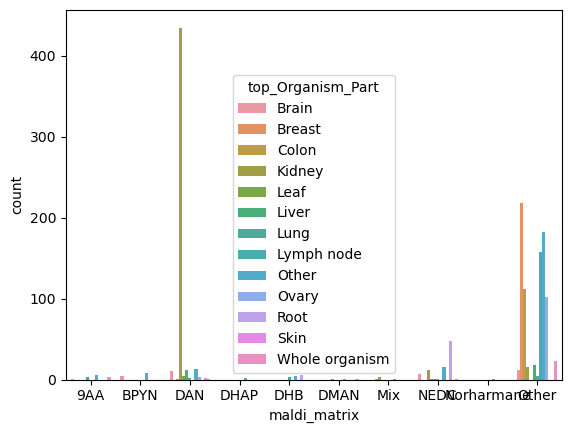

In [151]:
sns.countplot(data=adata_neg_met.obs, x='maldi_matrix', hue='top_Organism_Part')

In [152]:
adata_neg_met_matrix = adata_neg_met[adata_neg_met.obs['top_maldi_matrix']=='DAN',:]

sc.pp.pca(adata_neg_met_matrix)
sc.pp.neighbors(adata_neg_met_matrix, metric='cosine')
sc.tl.leiden(adata_neg_met_matrix)
sc.tl.umap(adata_neg_met_matrix)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


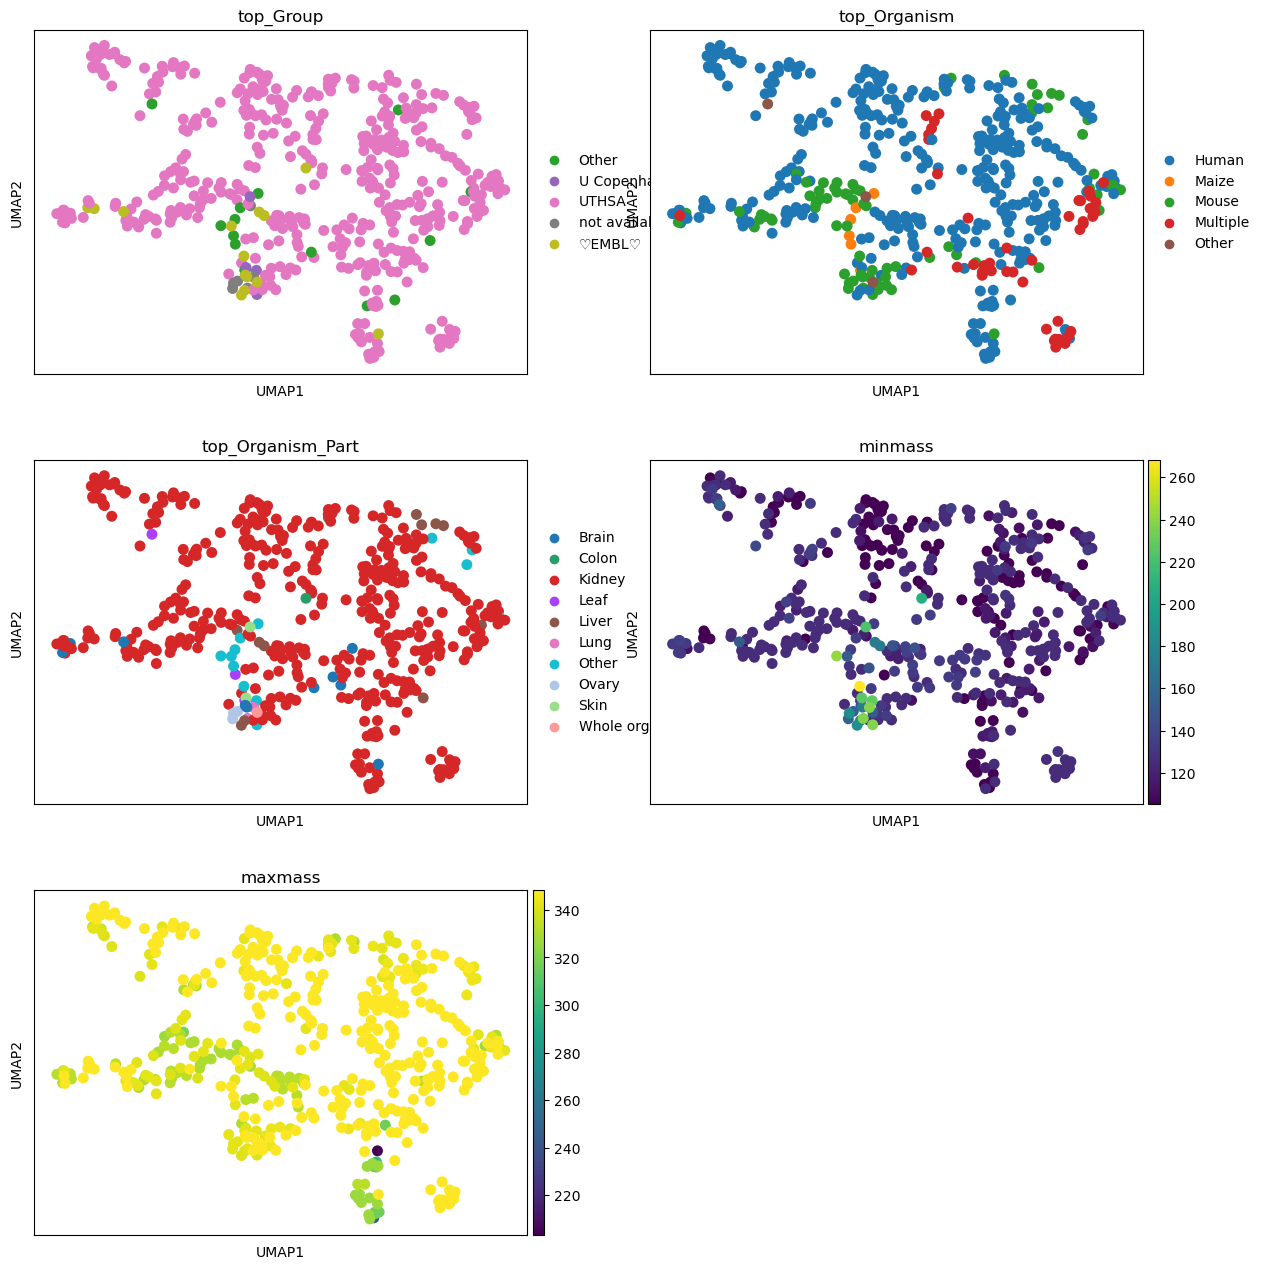

In [153]:
utils.update_minmax_mass(adata_neg_met_matrix)
sc.pl.umap(adata_neg_met_matrix, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

In [154]:
adata_neg_met_matrix

AnnData object with n_obs × n_vars = 483 × 279
    obs: 'Organism', 'Condition', 'Organism_Part', 'Polarity', 'maldi_matrix', 'Group', 'mzmin', 'mzmax', 'Analyzer', 'Ionisation_Source', 'top_Organism', 'top_Condition', 'top_Organism_Part', 'top_Polarity', 'top_maldi_matrix', 'top_Group', 'n_genes', 'leiden', 'minmass', 'maxmass'
    var: 'n_cells', 'mass'
    uns: 'neighbors', 'umap', 'pca', 'leiden', 'top_Group_colors', 'top_Organism_colors', 'top_Organism_Part_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### Select tissues

In [155]:
adata_neg_met_matrix.obs.Organism_Part.value_counts(ascending=False)

Kidney                                            435
Liver                                              12
Brain                                              10
Leaf                                                4
Seed                                                4
Other                                               3
Ovary                                               3
Brain | Lung | Liver | Heart | Kidney | Muscle      2
Lung                                                2
Skin                                                2
Skin Tumor                                          2
Colon                                               1
Spinal Cord                                         1
Spleen                                              1
Whole organism                                      1
Name: Organism_Part, dtype: int64

In [156]:
# Tissues
tissue_list = ['Kidney', 'Brain', 'Liver']

adata_neg_met_matrix_tissue = adata_neg_met_matrix[adata_neg_met_matrix.obs['Organism_Part'].isin(tissue_list), :]

#sc.pp.filter_genes(adata_pos_met_matrix_tissue, min_cells=5)

sc.pp.pca(adata_neg_met_matrix_tissue)
sc.pp.neighbors(adata_neg_met_matrix_tissue, metric='cosine')
sc.tl.leiden(adata_neg_met_matrix_tissue)
sc.tl.umap(adata_neg_met_matrix_tissue)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


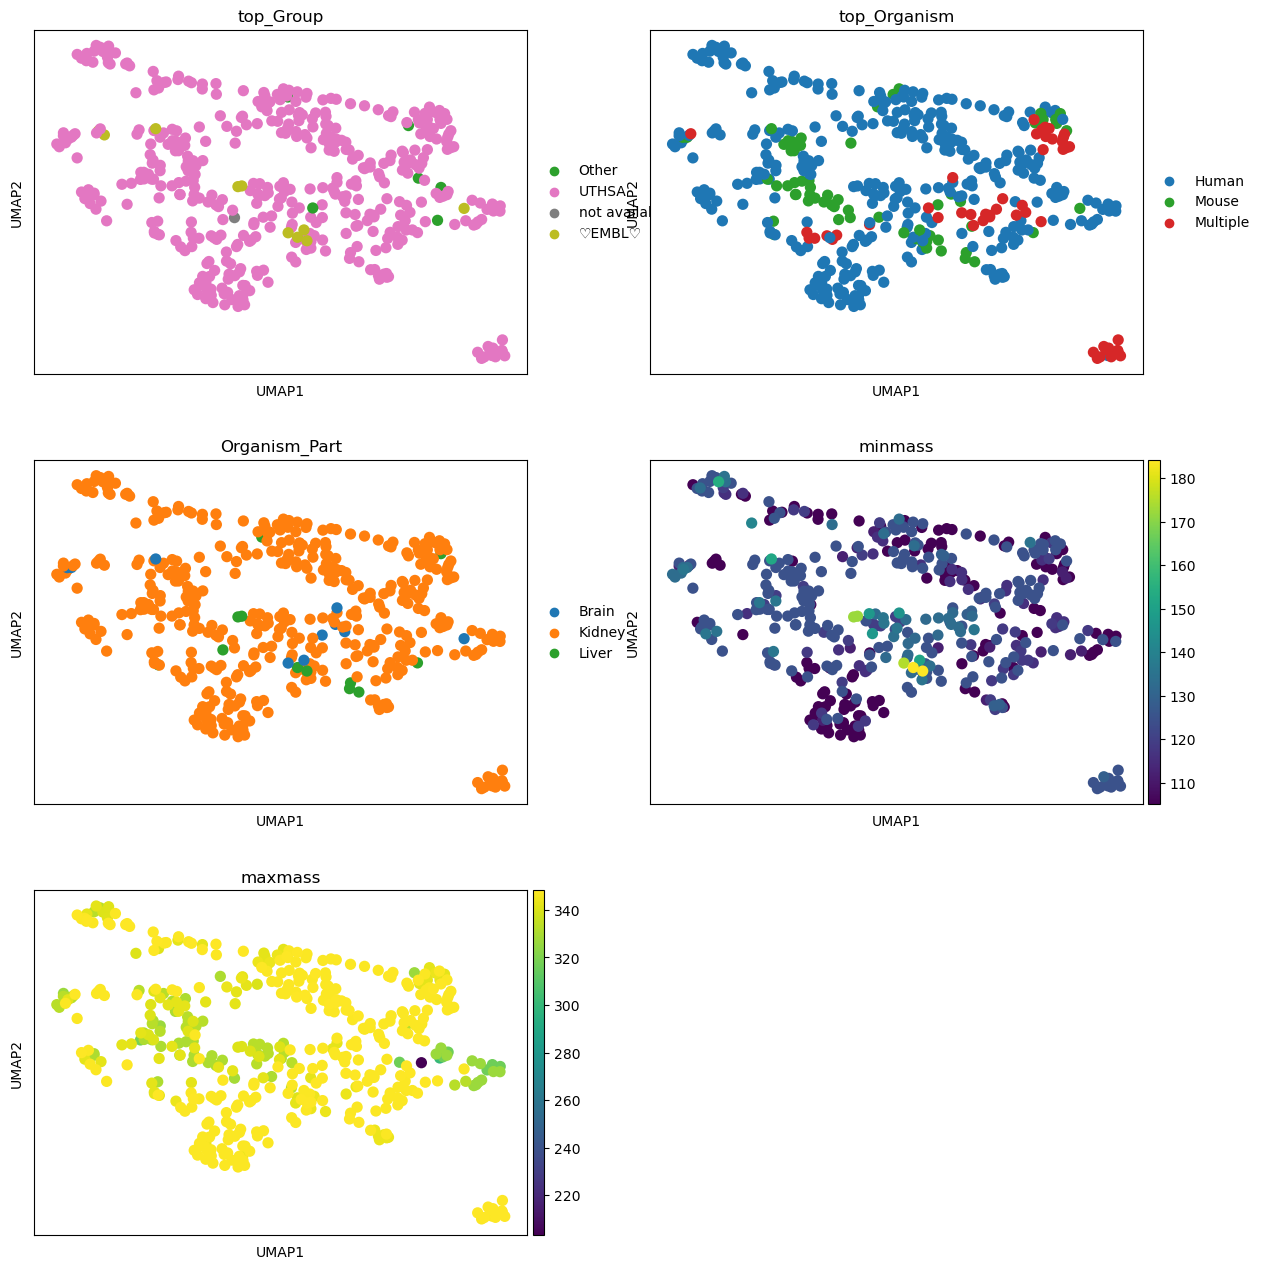

In [157]:
utils.update_minmax_mass(adata_neg_met_matrix_tissue)
sc.pl.umap(adata_neg_met_matrix_tissue, color=['top_Group', 'top_Organism', 'Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

In [159]:
adata_neg_met_matrix_tissue

AnnData object with n_obs × n_vars = 457 × 279
    obs: 'Organism', 'Condition', 'Organism_Part', 'Polarity', 'maldi_matrix', 'Group', 'mzmin', 'mzmax', 'Analyzer', 'Ionisation_Source', 'top_Organism', 'top_Condition', 'top_Organism_Part', 'top_Polarity', 'top_maldi_matrix', 'top_Group', 'n_genes', 'leiden', 'minmass', 'maxmass'
    var: 'n_cells', 'mass'
    uns: 'neighbors', 'umap', 'pca', 'leiden', 'top_Group_colors', 'top_Organism_colors', 'top_Organism_Part_colors', 'Organism_Part_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### Tissue prototyping

In [158]:
neg_met_mol_freq = {}
neg_met_mol2_freq = {}
neg_met_top_datasets = {}

mol_freq_cutoff = 0.1 # Initial: 0.1
top_ds_cutoff = 0.2 # Initial: 0.2

#### Kidney

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


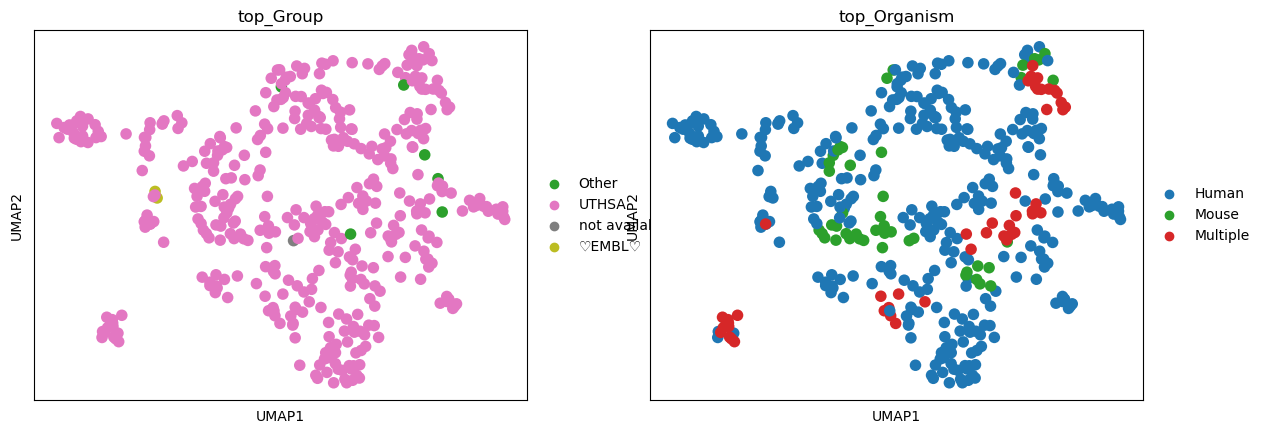

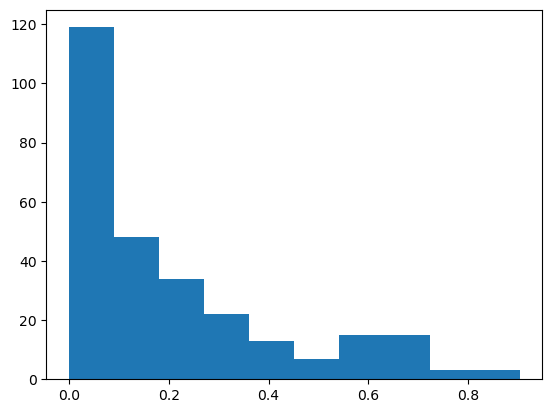

2022-10-31_22h30m32s    28
2022-10-31_22h06m17s    28
2022-10-31_22h01m40s    27
2022-10-31_21h48m35s    26
2022-07-16_08h03m42s    28
                        ..
2019-06-07_00h02m45s    27
2019-05-23_20h21m03s    27
2019-05-23_01h05m58s    26
2019-05-11_00h48m02s    27
2019-05-10_20h18m39s    28
Length: 102, dtype: int64
C2H8NO4P  -  ['O-Phosphoethanolamine']
C6H6O6  -  ['cis-Aconitic acid', 'trans-Aconitic acid', 'Dehydroascorbic acid', 'Dehydroascorbide(1-)']
C4H7NO4  -  ['L-Aspartic acid', 'D-Aspartic acid', 'Iminodiacetic acid']
C6H8O6  -  ['Ascorbic acid', 'D-Glucurono-6,3-lactone', '1,2,3-Propanetricarboxylic acid']
C5H7NO3  -  ['Pyroglutamic acid', 'Pyrroline hydroxycarboxylic acid', 'N-Acryloylglycine', '1-Pyrroline-4-hydroxy-2-carboxylate']
C5H14NO6P  -  ['Glycerylphosphorylethanolamine', 'sn-glycero-3-Phosphoethanolamine']
C18H13NO4  -  ['Hallacridone', 'Aristolodione']
C3H9O6P  -  ['Glycerol 3-phosphate', 'beta-Glycerophosphoric acid']
C5H9NO4  -  ['L-Glutamic acid', 'N-Meth

In [160]:
tissue = 'Kidney'
adat = adata_neg_met_matrix_tissue[adata_neg_met_matrix_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

utils.update_minmax_mass(adat)

sc.pl.umap(adat, color=['top_Group', 'top_Organism'], # , 'minmass', 'maxmass' 
           ncols=2)

neg_met_mol2_freq[tissue], neg_met_top_datasets[tissue] , neg_met_mol_freq[tissue] = utils.tissue_prototyping(adat, 
                                                                                                              mol_freq_cutoff=mol_freq_cutoff, 
                                                                                                              top_ds_cutoff=top_ds_cutoff)
#pd.DataFrame(mol_freq2.index).to_csv(os.path.join(enrichment_dir, f'features_pos_{tissue}.csv'))

print(neg_met_top_datasets[tissue])
utils.annotations_list(neg_met_mol2_freq[tissue].index, hmdb_v4, n=4)

#### Liver

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


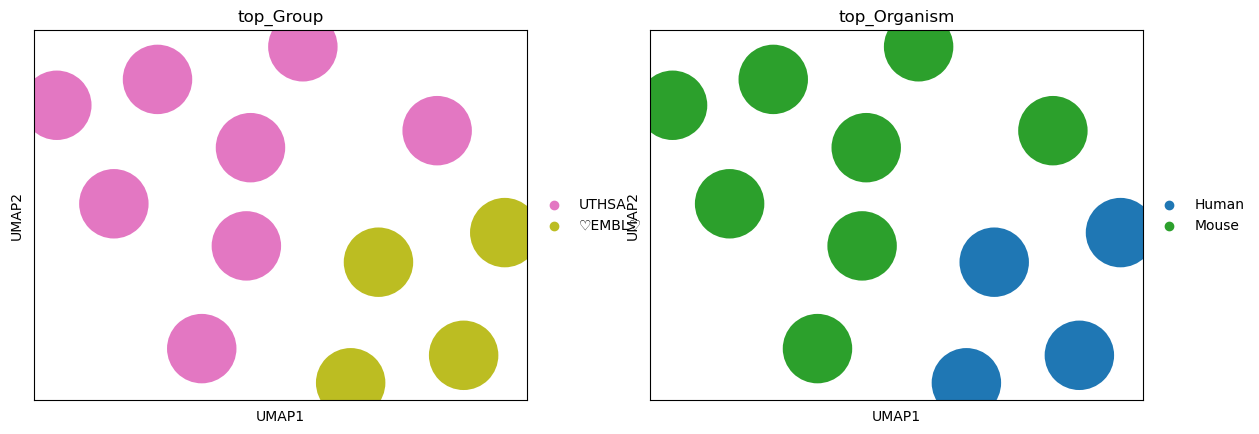

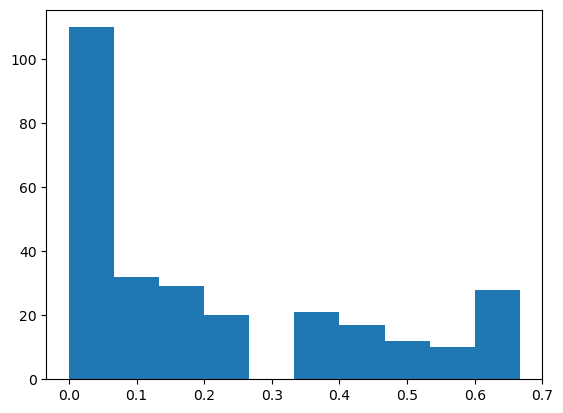

2022-11-21_22h57m17s    28
2022-11-21_23h06m51s    28
2022-11-21_22h52m55s    28
2022-11-21_22h54m09s    28
2022-11-21_23h18m11s    28
2022-11-21_23h17m14s    28
2022-11-21_23h30m51s    28
2022-11-21_23h25m13s    28
dtype: int64
C6H6O6  -  ['cis-Aconitic acid', 'trans-Aconitic acid', 'Dehydroascorbic acid', 'Dehydroascorbide(1-)']
C9H13N2O9P  -  ["Uridine 5'-monophosphate", "Pseudouridine 5'-phosphate", "Uridine 2'-phosphate", "Uridine 3'-monophosphate"]
C6H11NO4  -  ['Aminoadipic acid', 'Acetylhomoserine', "(±)-2,2'-Iminobispropanoic acid", 'Glutamic acid gamma-methyl ester']
C4H7NO4  -  ['L-Aspartic acid', 'D-Aspartic acid', 'Iminodiacetic acid']
C6H8O6  -  ['Ascorbic acid', 'D-Glucurono-6,3-lactone', '1,2,3-Propanetricarboxylic acid']
C5H4O5
C6H9N3O2  -  ['L-Histidine', 'L-2-Amino-3-(1-pyrazolyl)propanoic acid']
C18H13NO4  -  ['Hallacridone', 'Aristolodione']
C3H9O6P  -  ['Glycerol 3-phosphate', 'beta-Glycerophosphoric acid']
C7H11NO5  -  ['Glutarylglycine', 'N-Acetyl-L-glutamic aci

In [161]:
tissue = 'Liver'
adat = adata_neg_met_matrix_tissue[adata_neg_met_matrix_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

utils.update_minmax_mass(adat)

sc.pl.umap(adat, color=['top_Group', 'top_Organism'], # , 'minmass', 'maxmass' 
           ncols=2)

neg_met_mol2_freq[tissue], neg_met_top_datasets[tissue] , neg_met_mol_freq[tissue] = utils.tissue_prototyping(adat, 
                                                                                                              mol_freq_cutoff=mol_freq_cutoff, 
                                                                                                              top_ds_cutoff=top_ds_cutoff)
#pd.DataFrame(mol_freq2.index).to_csv(os.path.join(enrichment_dir, f'features_pos_{tissue}.csv'))

print(neg_met_top_datasets[tissue])
utils.annotations_list(neg_met_mol2_freq[tissue].index, hmdb_v4, n=4)

#### Brain

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


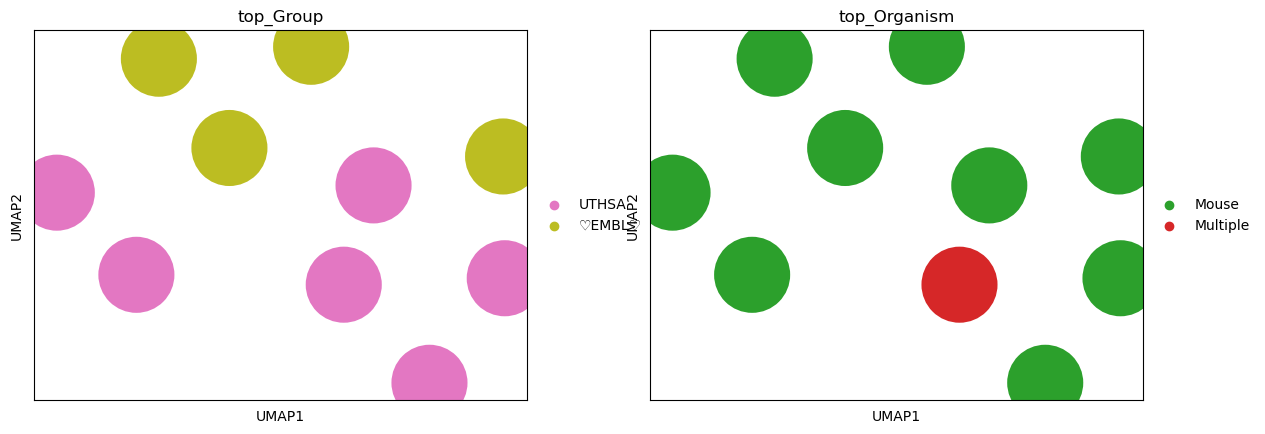

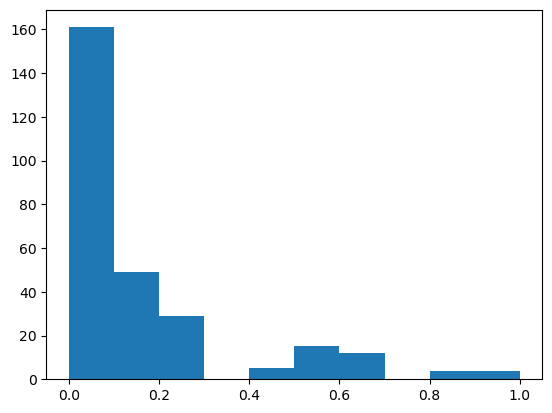

2021-09-27_21h29m45s    32
2021-09-27_21h27m38s    31
2021-09-27_19h51m20s    31
dtype: int64
C4H12NO4P  -  ['Phosphodimethylethanolamine']
C2H8NO4P  -  ['O-Phosphoethanolamine']
C6H9NO5  -  ['N-Acetyl-L-aspartic acid', 'N-Formyl-L-glutamic acid', 'D-N-(Carboxyacetyl)alanine', '2-Amino-3-oxoadipate']
C14H29NaO4S
C10H18O4  -  ['Sebacic acid', 'R-2-Hydroxy-3-methylbutanoic acid 3-Methylbutanoyl', 'Oxalic acid dibutyl ester', '2-Ethylsuberic acid']
C4H7NO4  -  ['L-Aspartic acid', 'D-Aspartic acid', 'Iminodiacetic acid']
C6H8O6  -  ['Ascorbic acid', 'D-Glucurono-6,3-lactone', '1,2,3-Propanetricarboxylic acid']
C10H8N2  -  ['3-Indoleacetonitrile']
C20H28O2  -  ['all-trans-Retinoic acid', '9-cis-Retinoic acid', '13-cis-Retinoic acid', '4-Oxoretinol']
C5H14NO6P  -  ['Glycerylphosphorylethanolamine', 'sn-glycero-3-Phosphoethanolamine']
C18H13NO4  -  ['Hallacridone', 'Aristolodione']
C3H9O6P  -  ['Glycerol 3-phosphate', 'beta-Glycerophosphoric acid']
C9H16O4  -  ['Azelaic acid', 'Nonate', 'cis-

In [162]:
tissue = 'Brain'
adat = adata_neg_met_matrix_tissue[adata_neg_met_matrix_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

utils.update_minmax_mass(adat)

sc.pl.umap(adat, color=['top_Group', 'top_Organism'], # , 'minmass', 'maxmass' 
           ncols=2)

neg_met_mol2_freq[tissue], neg_met_top_datasets[tissue] , neg_met_mol_freq[tissue] = utils.tissue_prototyping(adat, 
                                                                                                              mol_freq_cutoff=mol_freq_cutoff, 
                                                                                                              top_ds_cutoff=top_ds_cutoff)
#pd.DataFrame(mol_freq2.index).to_csv(os.path.join(enrichment_dir, f'features_pos_{tissue}.csv'))

print(neg_met_top_datasets[tissue])
utils.annotations_list(neg_met_mol2_freq[tissue].index, hmdb_v4, n=4)

### Tissue similarity

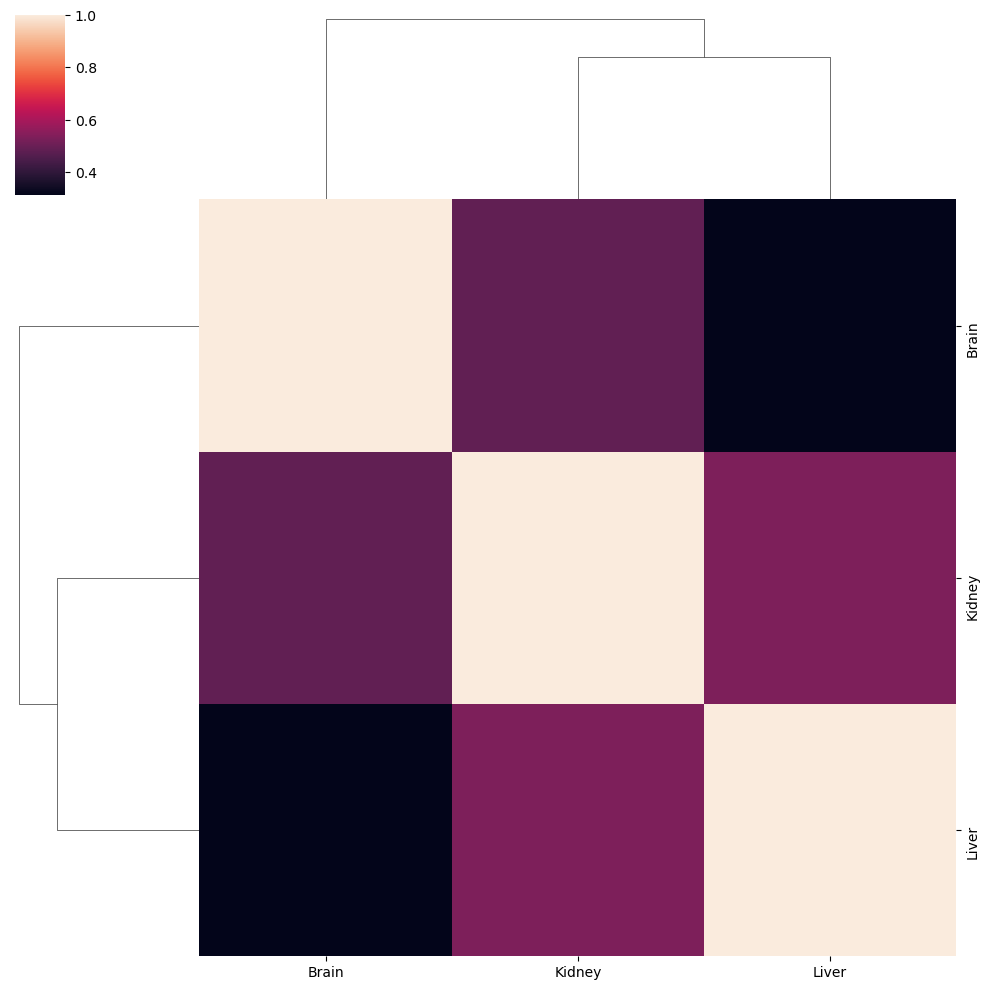

In [163]:
freq_tab = pd.DataFrame(neg_met_mol2_freq).transpose()
freq_tab[freq_tab.isna()] = 0
sim_tab = pd.DataFrame(pairwise_kernels(freq_tab, metric='cosine'), index=freq_tab.index, columns=freq_tab.index)
sns.clustermap(sim_tab)

/tmp/ipykernel_138/3157498515.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


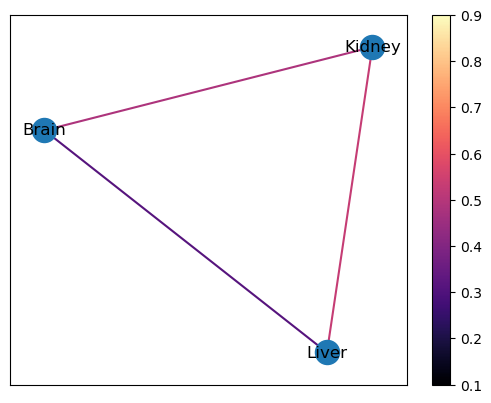

In [164]:
tmp_sim_tab = sim_tab.copy()
tmp_sim_tab[tmp_sim_tab<0.2] = 0
g = nx.from_pandas_adjacency(tmp_sim_tab)
g.remove_edges_from(nx.selfloop_edges(g))

pos = nx.spring_layout(g, k=1.3)
cm = plt.get_cmap('magma')
edge_weights = [d['weight'] for u, v, d in g.edges(data=True)]
vmin=0.1
vmax=0.9
nx.draw_networkx_edges(g, pos=pos, edge_color=edge_weights, edge_cmap=cm, width=1.5, edge_vmin=vmin, edge_vmax=vmax)
nx.draw_networkx_nodes(g, pos=pos)
nx.draw_networkx_labels(g, pos=pos)
sm = plt.cm.ScalarMappable(cmap=cm, norm=plt.Normalize(vmin=vmin, vmax=vmax))
plt.colorbar(sm)

plt.show()

### Prototypes on UMAP

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


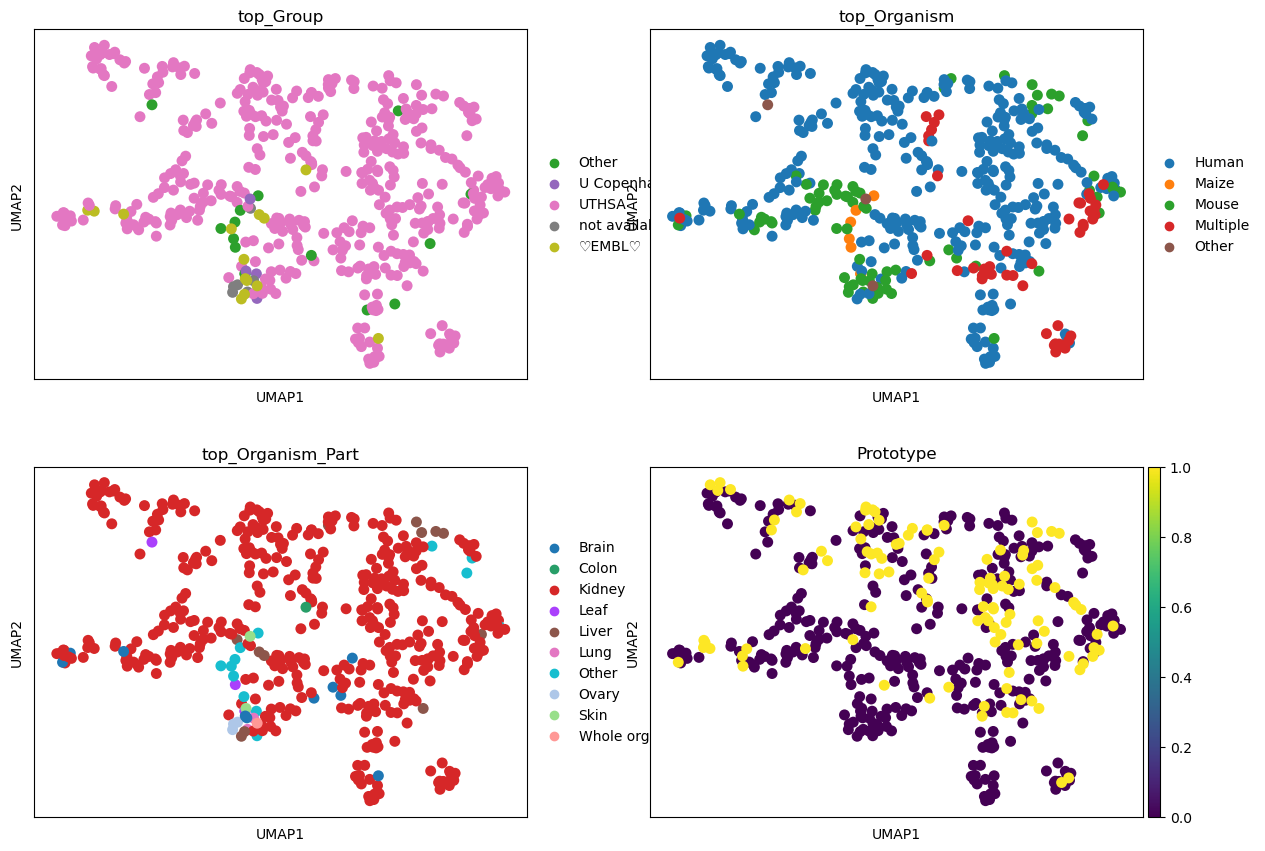

In [186]:
prot_list = utils.flatten([list(v.index) for v in neg_met_top_datasets.values()])
adata_neg_met_matrix.obs['Prototype'] = adata_neg_met_matrix.obs.index.isin(prot_list).astype('float64')

sc.pl.umap(adata_neg_met_matrix, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'Prototype'], 
           ncols=2)

## Lipids

### MZ range

In [165]:
adata_neg_lip = adata_neg[:,adata_neg.var['mass'] <= 900]
adata_neg_lip = adata_neg_lip[:,adata_neg_lip.var['mass'] >= 600]

sc.pp.filter_genes(adata_neg_lip, min_cells=100) # 200
sc.pp.filter_cells(adata_neg_lip, min_genes=20)
#sc.pp.normalize_total(adata_pos_met, target_sum=1e4)

sc.pp.pca(adata_neg_lip)
sc.pp.neighbors(adata_neg_lip, metric='cosine')
sc.tl.leiden(adata_neg_lip)
sc.tl.umap(adata_neg_lip)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


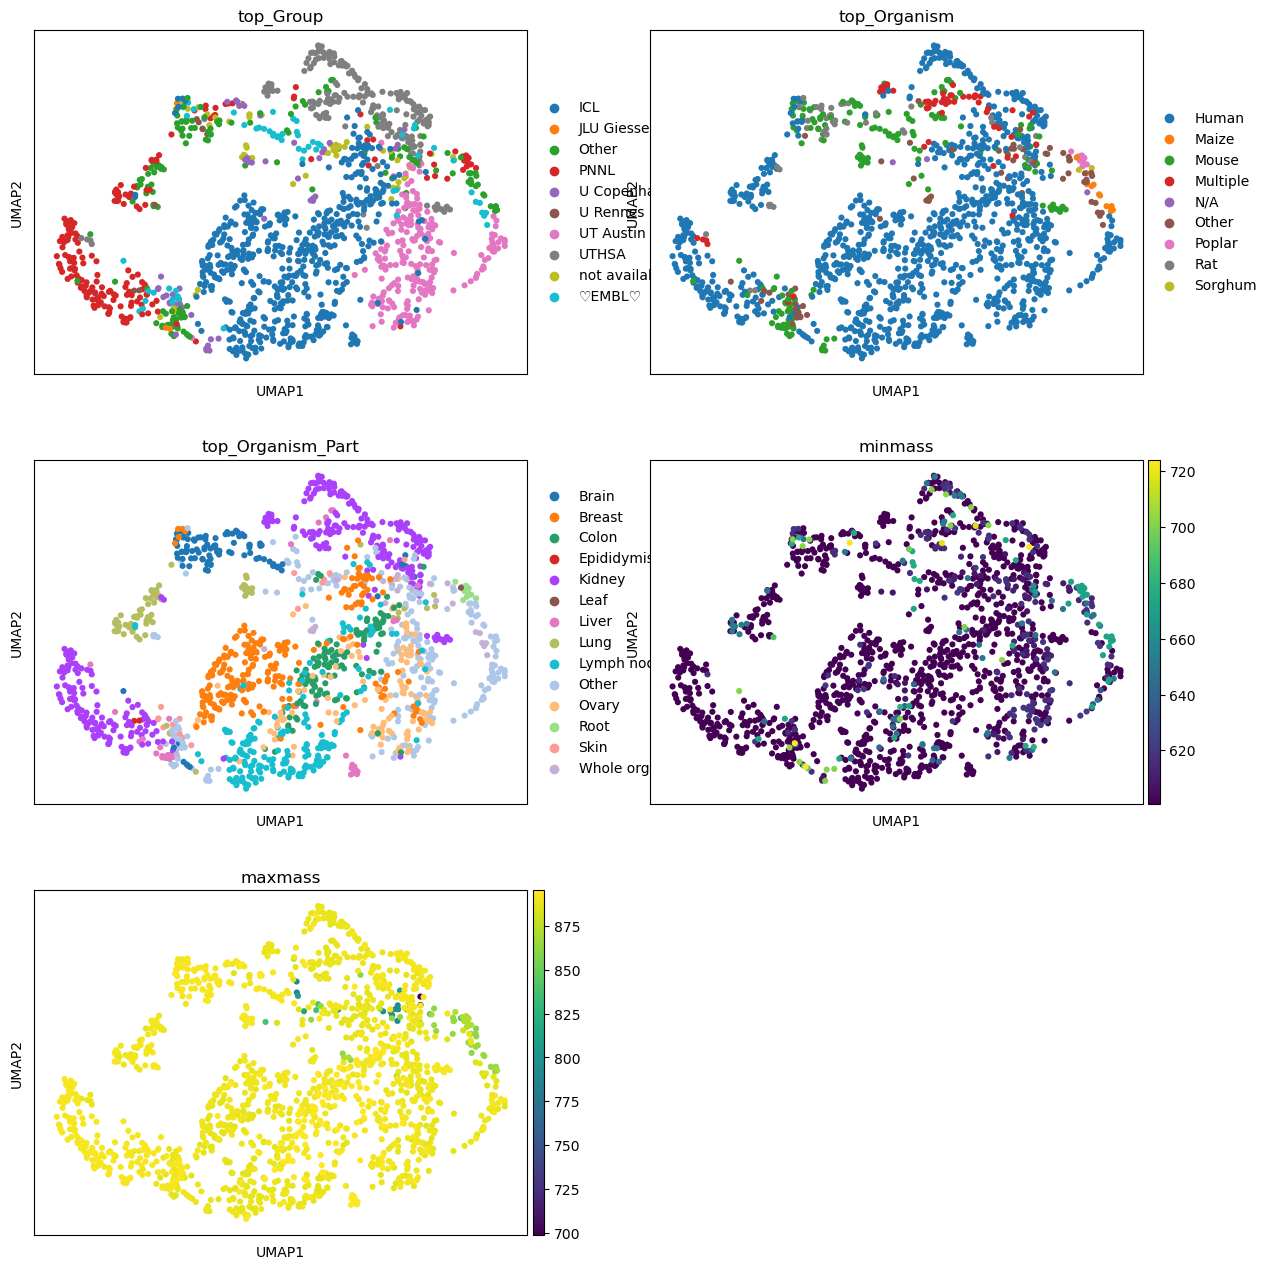

In [166]:
utils.update_minmax_mass(adata_neg_lip)
sc.pl.umap(adata_neg_lip, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

In [168]:
adata_neg_lip

AnnData object with n_obs × n_vars = 1530 × 288
    obs: 'Organism', 'Condition', 'Organism_Part', 'Polarity', 'maldi_matrix', 'Group', 'mzmin', 'mzmax', 'Analyzer', 'Ionisation_Source', 'top_Organism', 'top_Condition', 'top_Organism_Part', 'top_Polarity', 'top_maldi_matrix', 'top_Group', 'n_genes', 'leiden', 'minmass', 'maxmass'
    var: 'n_cells', 'mass'
    uns: 'neighbors', 'umap', 'pca', 'leiden', 'top_Group_colors', 'top_Organism_colors', 'top_Organism_Part_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### Matrix

<AxesSubplot: xlabel='maldi_matrix', ylabel='count'>

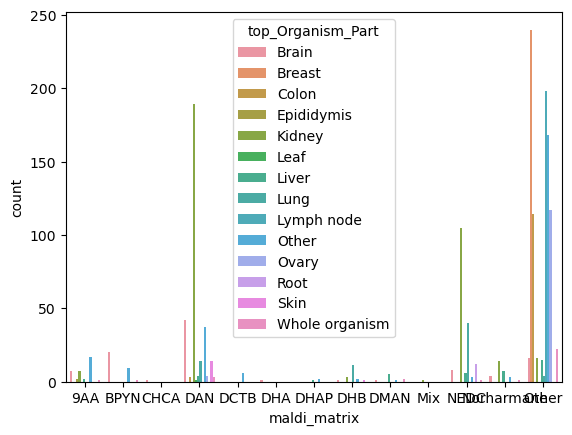

In [169]:
sns.countplot(data=adata_neg_lip.obs, x='maldi_matrix', hue='top_Organism_Part')

In [170]:
adata_neg_lip_matrix = adata_neg_lip[adata_neg_lip.obs['top_maldi_matrix']=='DAN',:]

sc.pp.pca(adata_neg_lip_matrix)
sc.pp.neighbors(adata_neg_lip_matrix, metric='cosine')
sc.tl.leiden(adata_neg_lip_matrix)
sc.tl.umap(adata_neg_lip_matrix)

In [ ]:
utils.update_minmax_mass(adata_neg_lip_matrix)
sc.pl.umap(adata_neg_lip_matrix, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

In [171]:
adata_neg_lip_matrix

AnnData object with n_obs × n_vars = 311 × 288
    obs: 'Organism', 'Condition', 'Organism_Part', 'Polarity', 'maldi_matrix', 'Group', 'mzmin', 'mzmax', 'Analyzer', 'Ionisation_Source', 'top_Organism', 'top_Condition', 'top_Organism_Part', 'top_Polarity', 'top_maldi_matrix', 'top_Group', 'n_genes', 'leiden', 'minmass', 'maxmass'
    var: 'n_cells', 'mass'
    uns: 'neighbors', 'umap', 'pca', 'leiden', 'top_Group_colors', 'top_Organism_colors', 'top_Organism_Part_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### Select tissues

In [172]:
adata_neg_lip_matrix.obs.Organism_Part.value_counts(ascending=False)

Kidney                                            189
Brain                                              42
Skin                                               14
Lung                                               14
Seed                                                7
Mammary gland                                       5
Liver                                               4
Ovary                                               4
Skin Tumor                                          4
Spleen                                              4
Embryo                                              3
Brain | Lung | Liver | Heart | Kidney | Muscle      3
PSM                                                 3
Colon                                               3
Cervix | Muscle                                     3
Whole organism                                      3
Multiple                                            2
Eye                                                 1
Leaf                        

In [173]:
# Tissues
tissue_list = ['Kidney', 'Brain', 'Lung', 'Skin']

adata_neg_lip_matrix_tissue = adata_neg_lip_matrix[adata_neg_lip_matrix.obs['Organism_Part'].isin(tissue_list), :]

#sc.pp.filter_genes(adata_pos_met_matrix_tissue, min_cells=5)

sc.pp.pca(adata_neg_lip_matrix_tissue)
sc.pp.neighbors(adata_neg_lip_matrix_tissue, metric='cosine')
sc.tl.leiden(adata_neg_lip_matrix_tissue)
sc.tl.umap(adata_neg_lip_matrix_tissue)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


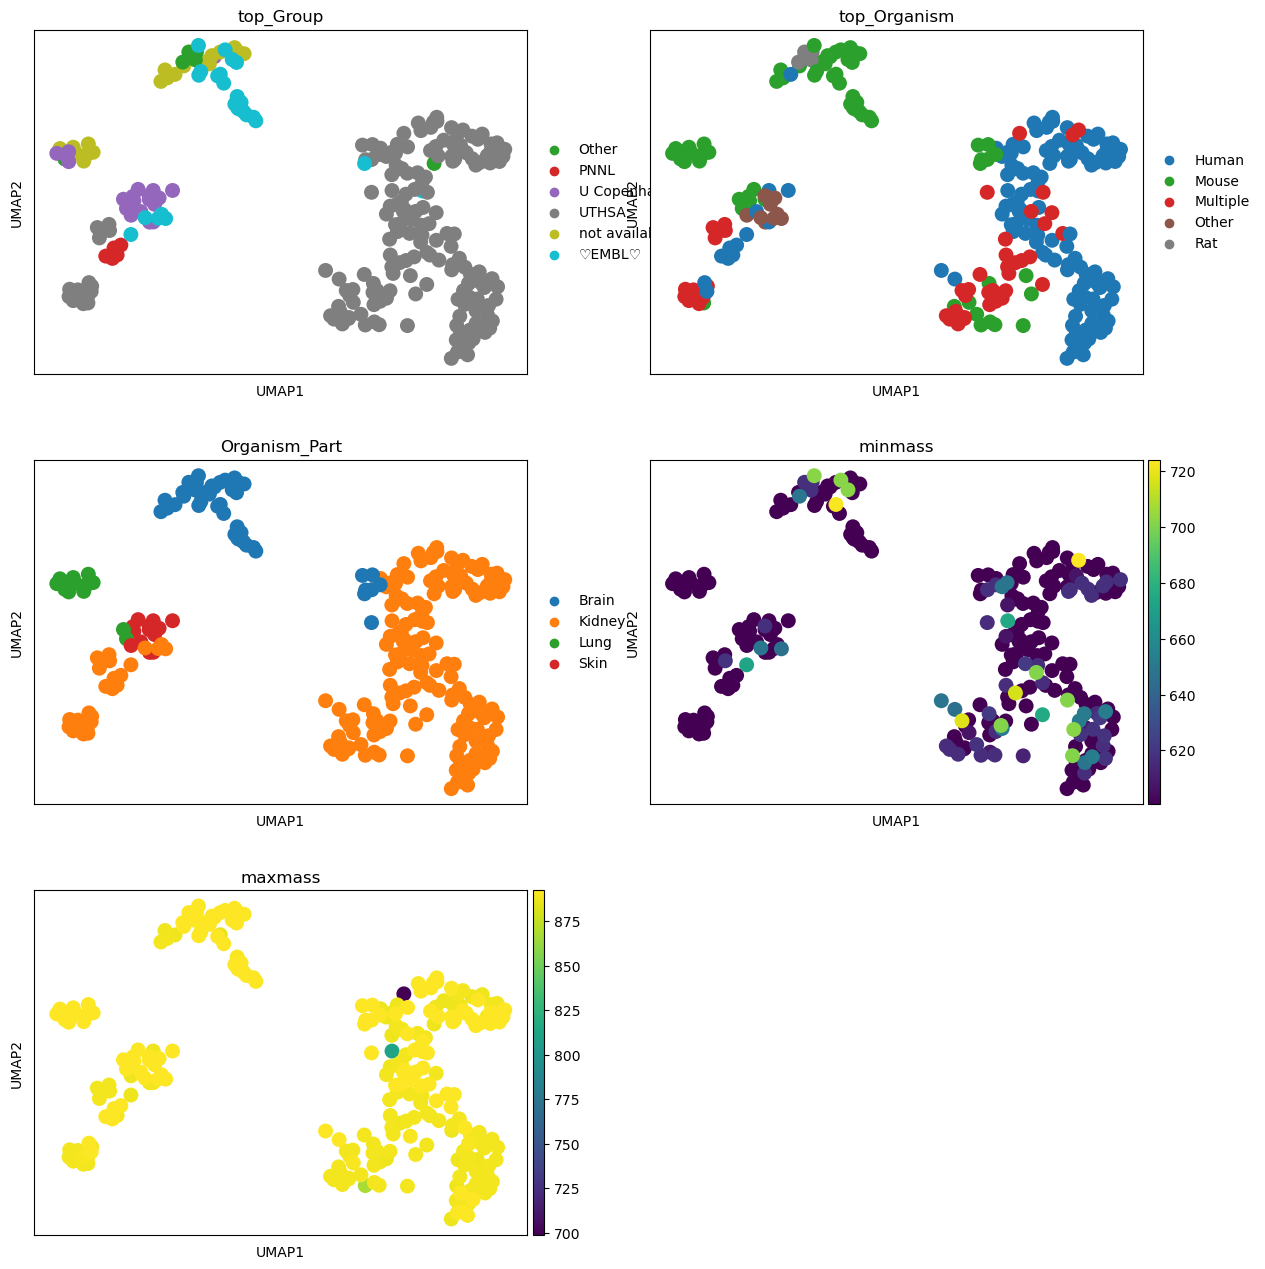

In [174]:
utils.update_minmax_mass(adata_neg_lip_matrix_tissue)
sc.pl.umap(adata_neg_lip_matrix_tissue, color=['top_Group', 'top_Organism', 'Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

In [175]:
adata_neg_lip_matrix_tissue

AnnData object with n_obs × n_vars = 259 × 288
    obs: 'Organism', 'Condition', 'Organism_Part', 'Polarity', 'maldi_matrix', 'Group', 'mzmin', 'mzmax', 'Analyzer', 'Ionisation_Source', 'top_Organism', 'top_Condition', 'top_Organism_Part', 'top_Polarity', 'top_maldi_matrix', 'top_Group', 'n_genes', 'leiden', 'minmass', 'maxmass'
    var: 'n_cells', 'mass'
    uns: 'neighbors', 'umap', 'pca', 'leiden', 'top_Group_colors', 'top_Organism_colors', 'top_Organism_Part_colors', 'Organism_Part_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### Tissue Prototyping

In [176]:
neg_lip_mol_freq = {}
neg_lip_mol2_freq = {}
neg_lip_top_datasets = {}

mol_freq_cutoff = 0.1 # Initial: 0.1
top_ds_cutoff = 0.2 # Initial: 0.2

#### Brain


/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


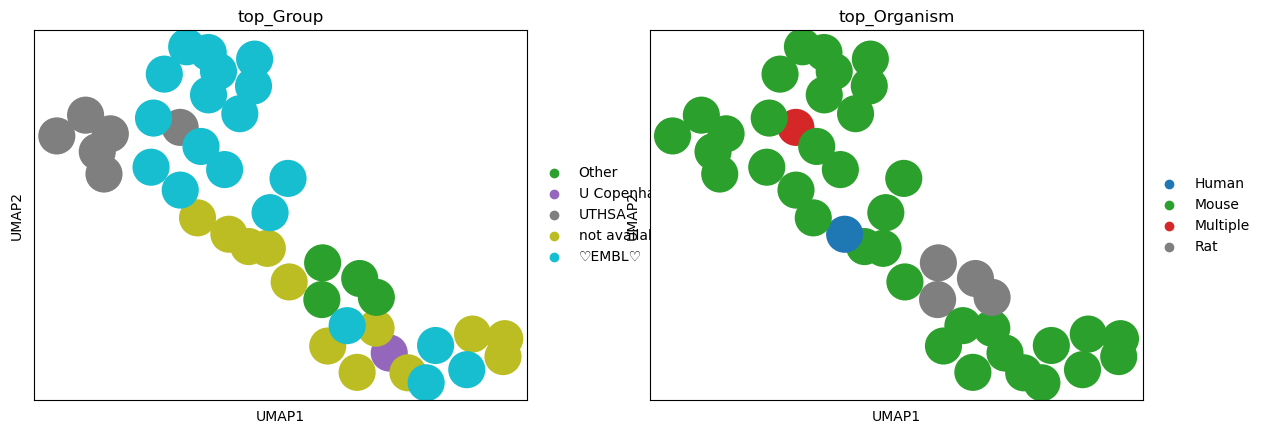

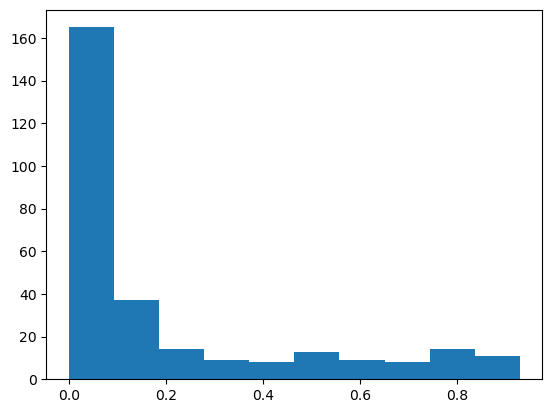

2022-12-12_09h28m41s    31
2021-04-14_18h12m56s    30
2021-09-27_21h29m45s    30
2021-09-27_19h51m20s    30
2021-03-22_14h42m06s    30
2020-09-24_14h43m10s    31
2016-11-18_06h01m50s    30
2017-03-14_06h00m36s    30
2017-08-08_08h49m46s    30
2017-08-15_13h02m38s    30
2017-08-15_19h13m44s    30
2017-08-16_08h30m18s    30
2017-08-18_16h00m58s    31
2017-08-23_16h56m26s    30
2017-09-14_13h43m01s    30
dtype: int64
C43H73O8P  -  ['PA(18:0/22:6(4Z,7Z,10Z,13Z,16Z,19Z))', 'PA(18:1(11Z)/22:5(4Z,7Z,10Z,13Z,16Z))', 'PA(18:1(11Z)/22:5(7Z,10Z,13Z,16Z,19Z))', 'PA(18:1(9Z)/22:5(4Z,7Z,10Z,13Z,16Z))']
C43H76NO8P  -  ['PC(15:0/20:5(5Z,8Z,11Z,14Z,17Z))', 'PC(20:5(5Z,8Z,11Z,14Z,17Z)/15:0)', 'PE(16:0/22:5(4Z,7Z,10Z,13Z,16Z))', 'PE(16:0/22:5(7Z,10Z,13Z,16Z,19Z))']
C43H78NO7P  -  ['PE(P-18:0/20:4(5Z,8Z,11Z,14Z))', 'PE(20:3(5Z,8Z,11Z)/P-18:1(11Z))', 'PE(20:3(5Z,8Z,11Z)/P-18:1(9Z))', 'PE(20:3(8Z,11Z,14Z)/P-18:1(11Z))']
C39H73O8P  -  ['PA(18:0/18:2(9Z,12Z))', 'PA(18:1(11Z)/18:1(11Z))', 'PA(18:1(11Z)/18:1(9Z

In [177]:
tissue = 'Brain'
adat = adata_neg_lip_matrix_tissue[adata_neg_lip_matrix_tissue.obs['Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

utils.update_minmax_mass(adat)

sc.pl.umap(adat, color=['top_Group', 'top_Organism'], # , 'minmass', 'maxmass' 
           ncols=2)

neg_lip_mol2_freq[tissue], neg_lip_top_datasets[tissue] , neg_lip_mol_freq[tissue] = utils.tissue_prototyping(adat, 
                                                                                                              mol_freq_cutoff=mol_freq_cutoff, 
                                                                                                              top_ds_cutoff=top_ds_cutoff)
#pd.DataFrame(mol_freq2.index).to_csv(os.path.join(enrichment_dir, f'features_pos_{tissue}.csv'))

print(neg_lip_top_datasets[tissue])
utils.annotations_list(neg_lip_mol2_freq[tissue].index, hmdb_v4, n=4)

#### Kidney

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


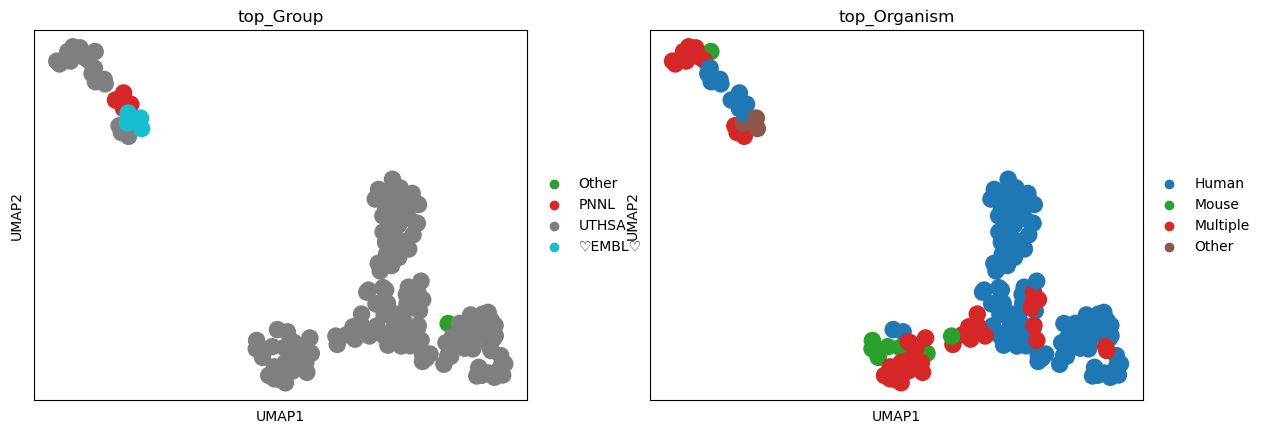

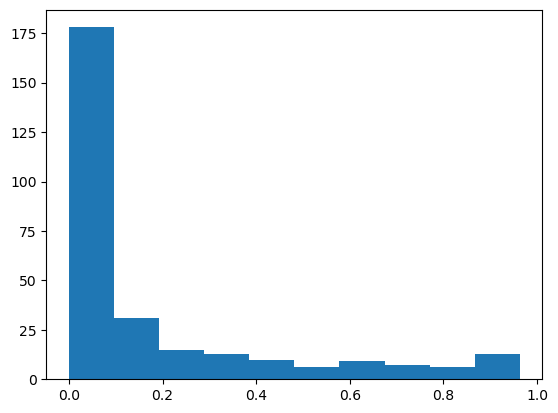

2021-07-26_19h51m51s    29
2021-07-26_19h51m20s    29
2020-12-13_23h30m59s    30
2020-12-13_23h08m12s    30
2020-12-11_19h37m54s    30
2020-12-11_19h31m26s    30
2020-12-11_19h22m09s    29
2020-12-11_18h54m41s    30
2020-12-09_23h36m48s    29
2020-12-09_21h57m28s    30
2020-12-09_21h51m46s    30
2020-12-09_21h47m14s    30
2020-12-09_21h41m46s    29
2020-12-05_14h58m17s    30
2020-12-05_14h54m27s    30
2020-12-05_14h49m21s    30
2020-12-04_19h16m17s    30
2020-12-04_18h52m45s    29
2020-12-04_18h37m03s    30
2019-11-15_22h06m33s    29
2019-11-15_22h02m57s    30
2019-11-15_20h55m40s    30
2019-11-15_20h49m52s    30
2019-11-15_20h42m46s    30
2019-10-29_21h43m57s    30
2019-10-29_21h40m16s    29
2019-10-04_18h04m43s    30
2019-10-04_17h59m03s    29
2019-10-03_17h21m22s    29
2019-09-12_19h53m18s    29
2019-09-12_19h43m40s    30
2019-09-12_00h42m06s    30
2019-09-12_00h37m23s    29
2019-09-11_23h54m26s    29
2019-09-11_23h46m54s    29
2019-09-06_21h51m25s    30
2019-09-06_21h31m18s    30
2

In [178]:
tissue = 'Kidney'
adat = adata_neg_lip_matrix_tissue[adata_neg_lip_matrix_tissue.obs['Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

utils.update_minmax_mass(adat)

sc.pl.umap(adat, color=['top_Group', 'top_Organism'], # , 'minmass', 'maxmass' 
           ncols=2)

neg_lip_mol2_freq[tissue], neg_lip_top_datasets[tissue] , neg_lip_mol_freq[tissue] = utils.tissue_prototyping(adat, 
                                                                                                              mol_freq_cutoff=mol_freq_cutoff, 
                                                                                                              top_ds_cutoff=top_ds_cutoff)
#pd.DataFrame(mol_freq2.index).to_csv(os.path.join(enrichment_dir, f'features_pos_{tissue}.csv'))

print(neg_lip_top_datasets[tissue])
utils.annotations_list(neg_lip_mol2_freq[tissue].index, hmdb_v4, n=4)

#### Lung

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


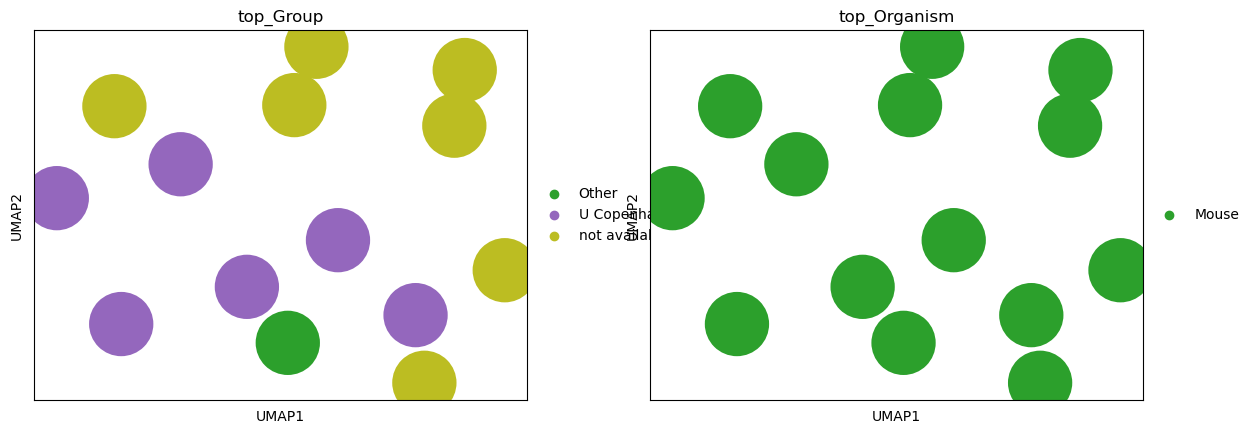

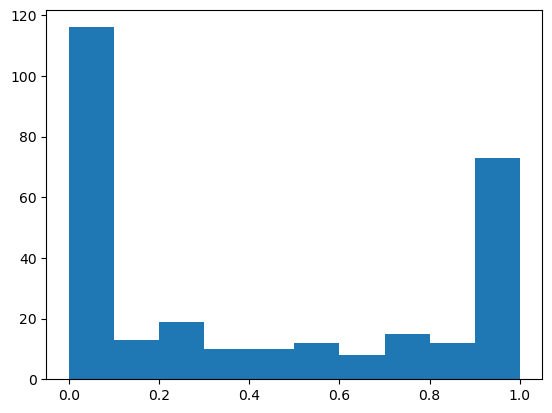

2022-05-17_15h40m15s    57
2022-03-08_16h44m33s    57
2022-03-07_11h16m23s    57
2022-03-04_11h13m43s    57
2022-03-02_15h56m01s    57
2022-02-28_12h37m31s    57
2022-02-22_11h06m11s    57
2022-02-14_11h58m38s    57
2019-01-17_19h54m30s    57
2018-10-31_10h26m49s    57
2018-10-18_15h53m44s    57
2018-10-16_09h53m21s    57
2018-10-12_09h25m16s    57
2018-10-12_09h21m15s    57
dtype: int64
C34H68NO6P  -  ['CerP(d18:1/16:0)']
C41H74NO8P  -  ['PC(15:0/18:4(6Z,9Z,12Z,15Z))', 'PC(18:4(6Z,9Z,12Z,15Z)/15:0)', 'PE(14:0/22:4(7Z,10Z,13Z,16Z))', 'PE(16:0/20:4(5Z,8Z,11Z,14Z))']
C39H69O8P  -  ['1,2-Di-(9Z,12Z-octadecadienoyl)-sn-glycero-3-phosphate', 'PA(14:0/22:4(7Z,10Z,13Z,16Z))', 'PA(16:0/20:4(5Z,8Z,11Z,14Z))', 'PA(16:1(9Z)/20:3(5Z,8Z,11Z))']
C44H79O10P  -  ['PG(16:0/22:4(7Z,10Z,13Z,16Z))', 'PG(18:0/20:4(5Z,8Z,11Z,14Z))', 'PG(18:1(11Z)/20:3(5Z,8Z,11Z))', 'PG(18:1(11Z)/20:3(8Z,11Z,14Z))']
C42H75O10P  -  ['PG(16:0/20:4(5Z,8Z,11Z,14Z))', 'PG(16:1(9Z)/20:3(5Z,8Z,11Z))', 'PG(16:1(9Z)/20:3(8Z,11Z,14Z))

In [179]:
tissue = 'Lung'
adat = adata_neg_lip_matrix_tissue[adata_neg_lip_matrix_tissue.obs['Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

utils.update_minmax_mass(adat)

sc.pl.umap(adat, color=['top_Group', 'top_Organism'], # , 'minmass', 'maxmass' 
           ncols=2)

neg_lip_mol2_freq[tissue], neg_lip_top_datasets[tissue] , neg_lip_mol_freq[tissue] = utils.tissue_prototyping(adat, 
                                                                                                              mol_freq_cutoff=mol_freq_cutoff, 
                                                                                                              top_ds_cutoff=top_ds_cutoff)
#pd.DataFrame(mol_freq2.index).to_csv(os.path.join(enrichment_dir, f'features_pos_{tissue}.csv'))

print(neg_lip_top_datasets[tissue])
utils.annotations_list(neg_lip_mol2_freq[tissue].index, hmdb_v4, n=4)

#### Skin

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


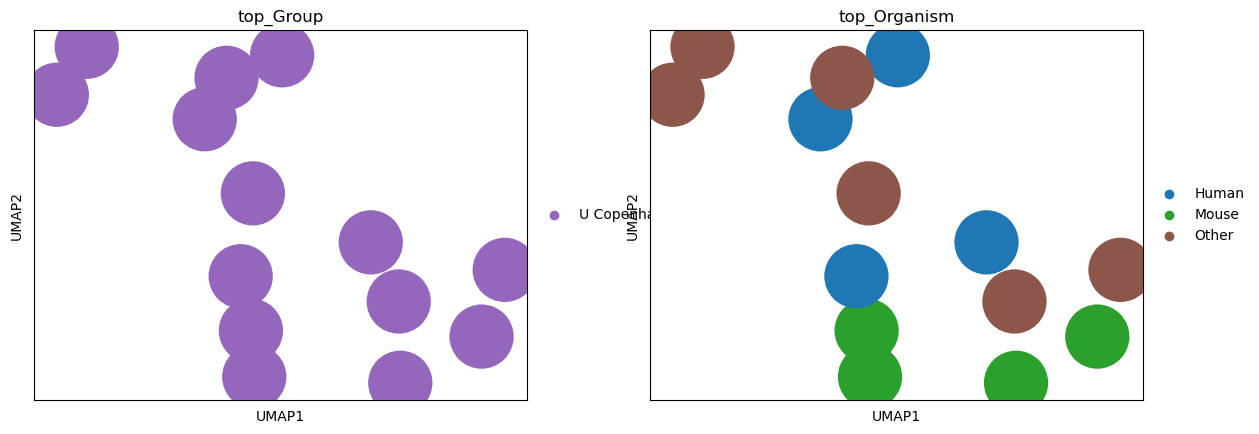

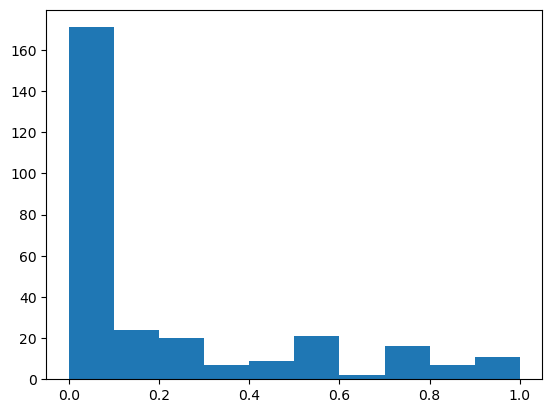

2019-10-29_16h53m33s    34
2018-07-05_15h25m32s    34
2018-07-05_13h22m46s    34
2018-07-05_10h44m16s    34
dtype: int64
C34H68NO6P  -  ['CerP(d18:1/16:0)']
C41H71O8P  -  ['PA(16:0/22:5(4Z,7Z,10Z,13Z,16Z))', 'PA(16:0/22:5(7Z,10Z,13Z,16Z,19Z))', 'PA(16:1(9Z)/22:4(7Z,10Z,13Z,16Z))', 'PA(18:0/20:5(5Z,8Z,11Z,14Z,17Z))']
C45H83O13P  -  ['PI(16:0/20:2(11Z,14Z))', 'PI(18:0/18:2(9Z,12Z))', 'PI(18:1(11Z)/18:1(11Z))', 'PI(18:1(11Z)/18:1(9Z))']
C45H80NO8P  -  ['PC(15:0/22:5(4Z,7Z,10Z,13Z,16Z))', 'PC(15:0/22:5(7Z,10Z,13Z,16Z,19Z))', 'PC(22:5(4Z,7Z,10Z,13Z,16Z)/15:0)', 'PC(22:5(7Z,10Z,13Z,16Z,19Z)/15:0)']
C46H93N2O6P  -  ['SM(d17:1/24:0)', 'SM(d18:1/23:0)']
C43H76NO8P  -  ['PC(15:0/20:5(5Z,8Z,11Z,14Z,17Z))', 'PC(20:5(5Z,8Z,11Z,14Z,17Z)/15:0)', 'PE(16:0/22:5(4Z,7Z,10Z,13Z,16Z))', 'PE(16:0/22:5(7Z,10Z,13Z,16Z,19Z))']
C43H82NO8P  -  ['PC(15:0/20:2(11Z,14Z))', 'PC(20:2(11Z,14Z)/15:0)', 'PE(14:1(9Z)/24:1(15Z))', 'PE(16:0/22:2(13Z,16Z))']
C43H78NO7P  -  ['PE(P-18:0/20:4(5Z,8Z,11Z,14Z))', 'PE(20:3(5Z,8Z,1

In [180]:
tissue = 'Skin'
adat = adata_neg_lip_matrix_tissue[adata_neg_lip_matrix_tissue.obs['Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

utils.update_minmax_mass(adat)

sc.pl.umap(adat, color=['top_Group', 'top_Organism'], # , 'minmass', 'maxmass' 
           ncols=2)

neg_lip_mol2_freq[tissue], neg_lip_top_datasets[tissue] , neg_lip_mol_freq[tissue] = utils.tissue_prototyping(adat, 
                                                                                                              mol_freq_cutoff=mol_freq_cutoff, 
                                                                                                              top_ds_cutoff=top_ds_cutoff)
#pd.DataFrame(mol_freq2.index).to_csv(os.path.join(enrichment_dir, f'features_pos_{tissue}.csv'))

print(neg_lip_top_datasets[tissue])
utils.annotations_list(neg_lip_mol2_freq[tissue].index, hmdb_v4, n=4)

### Tissue similarity

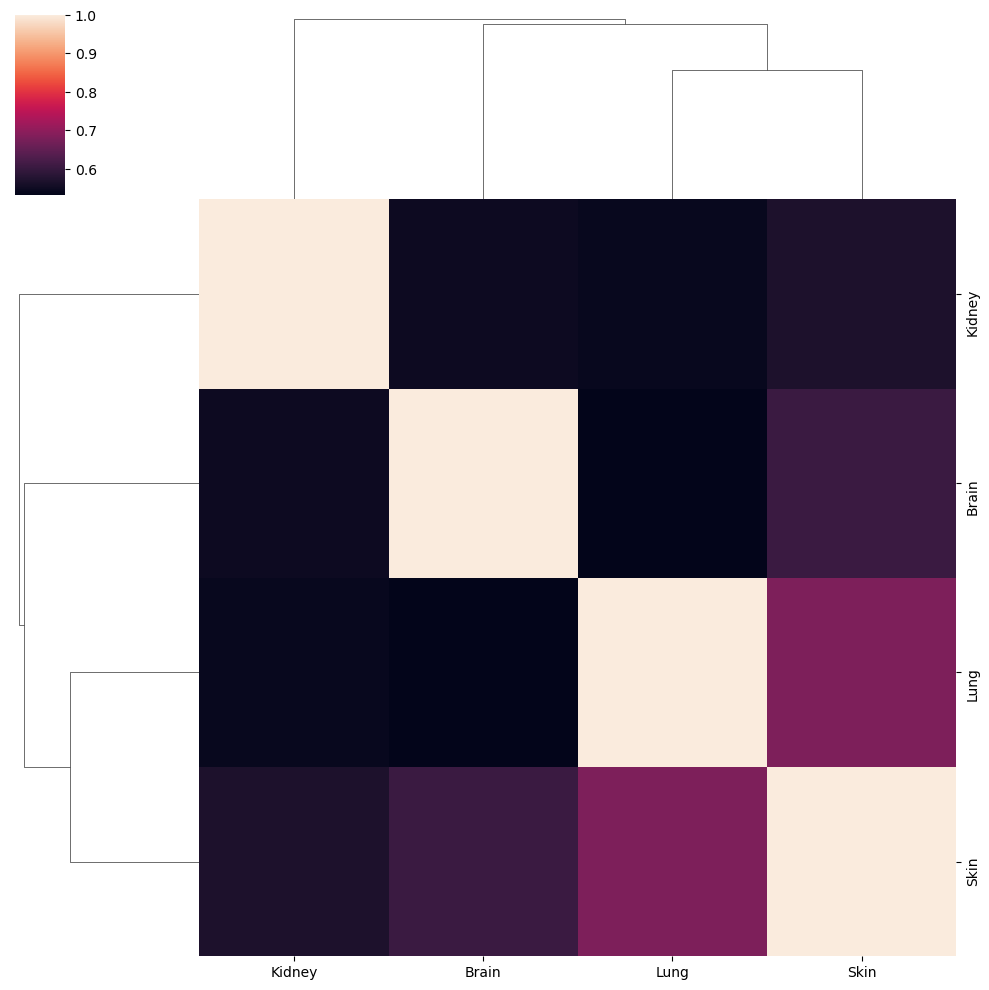

In [181]:
freq_tab = pd.DataFrame(neg_lip_mol2_freq).transpose()
freq_tab[freq_tab.isna()] = 0
sim_tab = pd.DataFrame(pairwise_kernels(freq_tab, metric='cosine'), index=freq_tab.index, columns=freq_tab.index)
sns.clustermap(sim_tab)

/tmp/ipykernel_138/3371371824.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


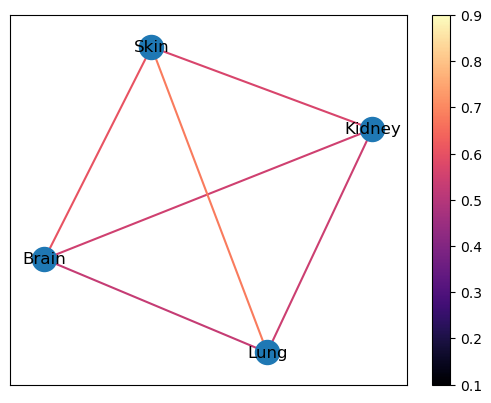

In [183]:
tmp_sim_tab = sim_tab.copy()
tmp_sim_tab[tmp_sim_tab<0.5] = 0
g = nx.from_pandas_adjacency(tmp_sim_tab)
g.remove_edges_from(nx.selfloop_edges(g))

pos = nx.spring_layout(g, k=1.3)
cm = plt.get_cmap('magma')
edge_weights = [d['weight'] for u, v, d in g.edges(data=True)]
vmin=0.1
vmax=0.9
nx.draw_networkx_edges(g, pos=pos, edge_color=edge_weights, edge_cmap=cm, width=1.5, edge_vmin=vmin, edge_vmax=vmax)
nx.draw_networkx_nodes(g, pos=pos)
nx.draw_networkx_labels(g, pos=pos)
sm = plt.cm.ScalarMappable(cmap=cm, norm=plt.Normalize(vmin=vmin, vmax=vmax))
plt.colorbar(sm)

plt.show()

### Prototypes on UMAP

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


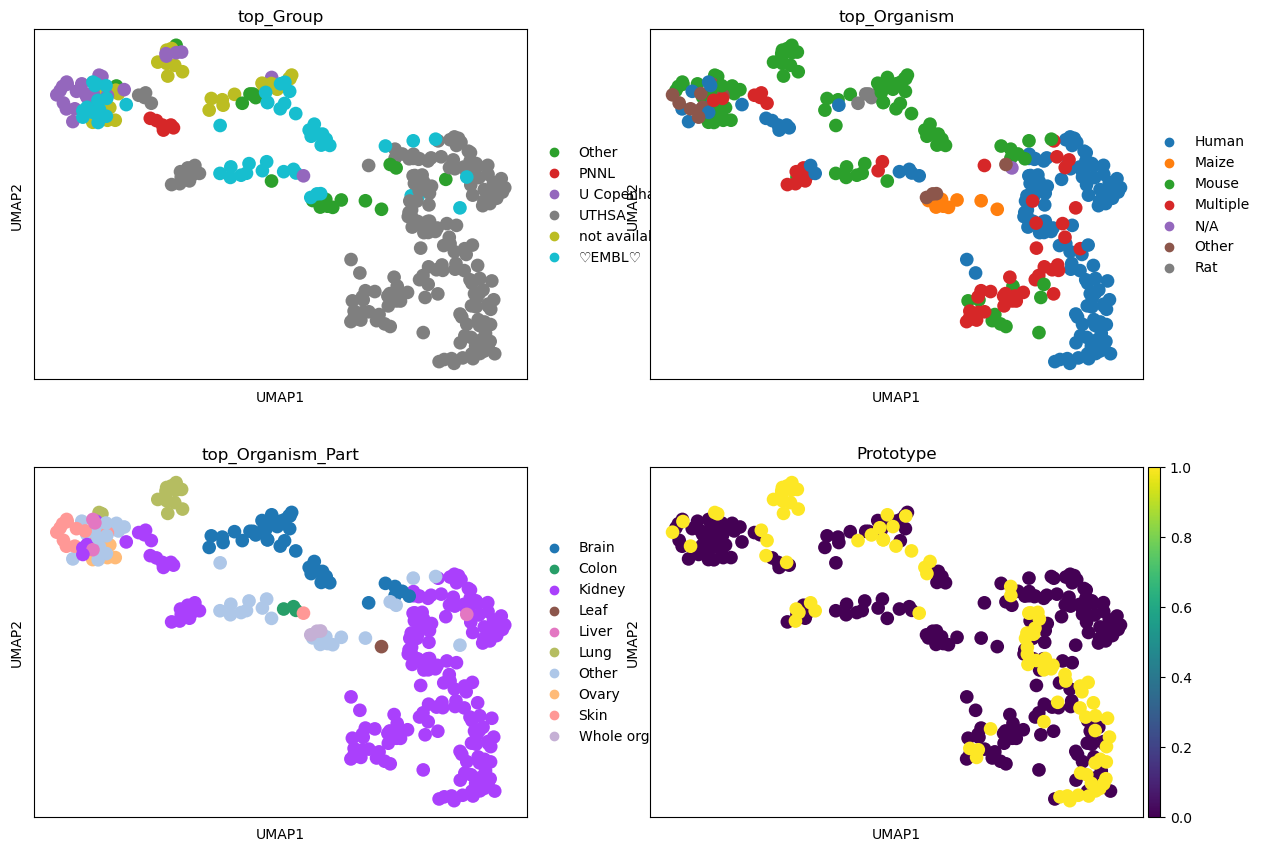

In [185]:
prot_list = utils.flatten([list(v.index) for v in neg_lip_top_datasets.values()])
adata_neg_lip_matrix.obs['Prototype'] = adata_neg_lip_matrix.obs.index.isin(prot_list).astype('float64')

sc.pl.umap(adata_neg_lip_matrix, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'Prototype'], 
           ncols=2)